# Monte Carlo Nullpoint Approach - Code Description

This is the central code for looking at nullpoints under a Jupyter Notebooks framework

This is the python script for replicating the Bi,Spencer 2D stabilization technique with the intention of varying TI for Eq.3 to observe the TI related nullpoint - this code has the potential to look at a histogram for each TI value or to look at the standard deviation across the population for a range of TI values

# Import Libraries

In [2]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
# import mpld3
# mpld3.enable_notebook()

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Set Options

In [3]:
#Initial Options
histPlot = False
stdPlot = True
cNPlot = True
denPlot = True      #Plot all estimated signals against the true signal 

# Initialize Parameters and Arrays

In [4]:
#Assumed echo time points
TE_series = np.arange(8, 512, 8) #ms units

######All Fixed parameters for code
#Parameters held constant
c1 = 0.5
c2 = 0.5
T21 = 45
T22 = 100
T11 = 600
T12 = 1200

initParams = np.array([c1, c2, T11, T12, T21, T22])

#Bound used during NLLS to constrain the upper bound on T2 values
T2_bound = 1000

#Zoom Fits range
rad = 0.05 #percent radius around the zoom fits

#Information determing TI range
bothTI = True
TI_numPoints = 31
TI_betPoints = 5
TI_befPoints = 5
TI_lb = 0.8
TI_ub = 1.2
assert(TI_ub>TI_lb)

#Parameters that dictate process related features
iterCount = 10000 #number of iterations that curveFit is applied
SNR = 1000

#Preparing TI array to loop through
alpha_array = np.linspace(TI_lb,TI_ub,TI_numPoints)
TI1star = np.log(2)*(T11)
TI1_array = alpha_array*TI1star

TI2star = np.log(2)*T12
TI2_array = alpha_array*TI2star

assert(TI1_array[np.size(TI1_array)-1] <= TI2_array[0])
bet_array = np.linspace(TI1_array[np.size(TI1_array)-1],TI2_array[0],TI_betPoints+2)
bet_array = bet_array[1:np.size(bet_array)-1]
assert(np.size(bet_array)==TI_betPoints)

bef_array = np.linspace(TI1_array[0]*2/3,TI1_array[0],TI_befPoints+1)
bef_array = bef_array[0:np.size(bet_array)-1]

if bothTI:
    TI_array = [*bef_array, *TI1_array, *bet_array, *TI2_array]
    betFill = np.zeros(TI_betPoints)
    befFill = np.zeros(TI_befPoints)
    alpha_array = [*befFill, *alpha_array, *betFill, *alpha_array]
else:
    TI_array = TI1_array

#Initializing all the storage matrices
#Storing all strings associated with titles
MonoTitle = ['d', 'T2']
ParamTitle_4p = ['d1', 'd2', 'T21', 'T22']
ParamTitle_6p = ['c1','c2','T11','T12','T21','T22']

round_Params = [round(num, 2) for num in initParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p)

#Initializing where all parameter values are stored
paramStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_4p)])
paramStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(MonoTitle)])
avgPStore = np.zeros([np.size(TI_array), np.size(ParamTitle_4p)])

#Storing all the estimated signals for each iteration and TI array
sigStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])
sigStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])

#All standard deviation of parameter values matrices
stdStore = np.zeros([np.size(TI_array),np.size(ParamTitle_4p)])
mono_std = np.zeros([np.size(TI_array),np.size(MonoTitle)])
std2Store = np.zeros([np.size(TI_array),np.size(ParamTitle_4p)])

#All error related matrices
RSS_Store = np.zeros([np.size(TI_array),iterCount])
errStore = np.zeros([np.size(TI_array),iterCount])
RSS_Store_1E = np.zeros([np.size(TI_array),iterCount])
errStore_1E = np.zeros([np.size(TI_array),iterCount])

#Condition number related matrix
CNStore = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_4p)])
avgCNStore = np.zeros([np.size(TI_array), np.size(ParamTitle_4p)])

#Title String
details = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) +" :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
            '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[TI_befPoints]) + "," + str(alpha_array[np.size(alpha_array)-1]) +
            '):: Points: ' + str(np.size(alpha_array)))

# Define Functions

In [5]:
#Defining the function of interest
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def Jacobian_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dc1, dc2, dT11, dT12, dT21, dT22), axis = -1)
    return jacobian

def Jacobian_4p(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

# Build Curve Fitting Dataset

  0%|          | 0/71 [00:00<?, ?it/s]

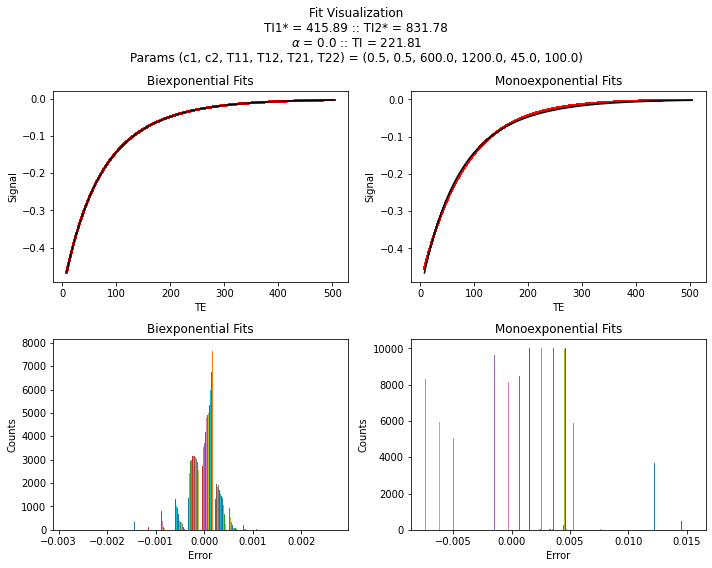

  1%|▏         | 1/71 [00:41<48:22, 41.46s/it]

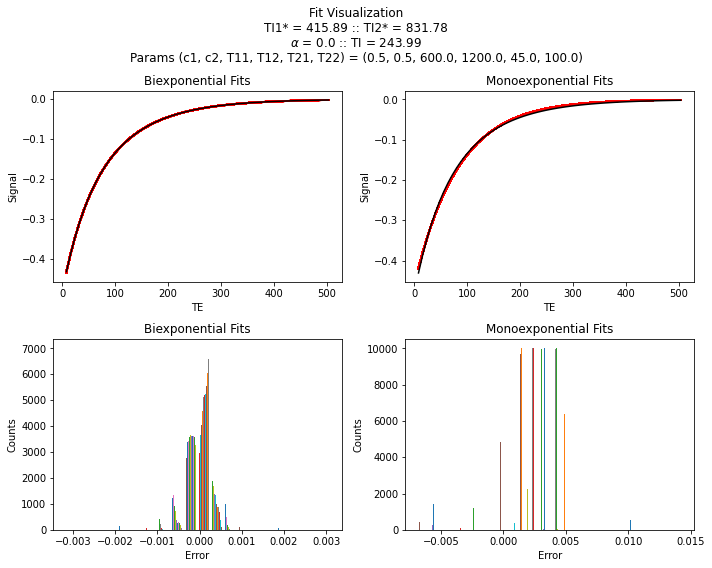

  3%|▎         | 2/71 [01:23<48:14, 41.94s/it]

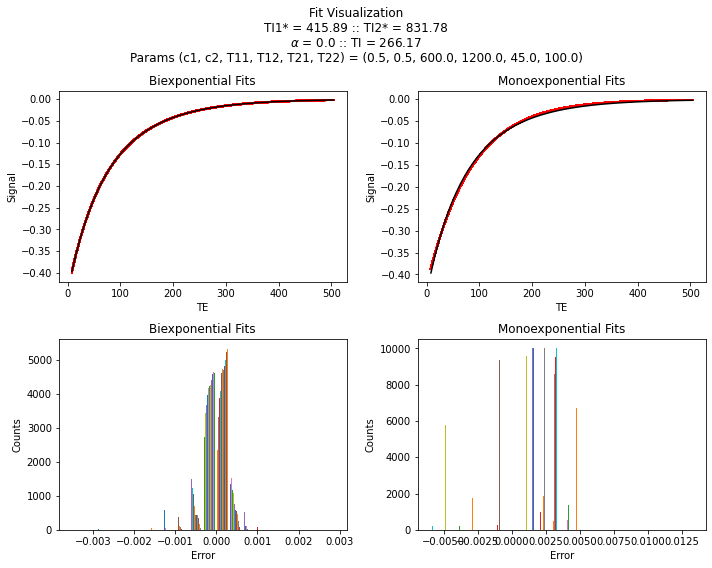

  4%|▍         | 3/71 [02:07<48:19, 42.64s/it]

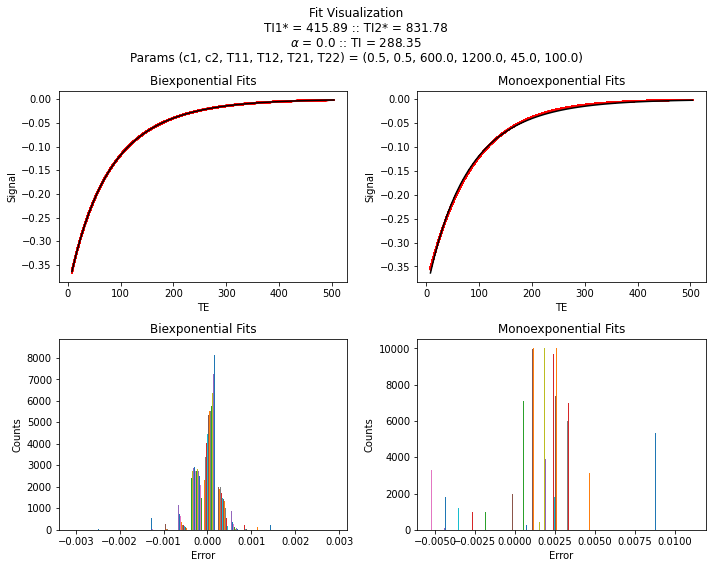

  6%|▌         | 4/71 [02:51<48:14, 43.20s/it]

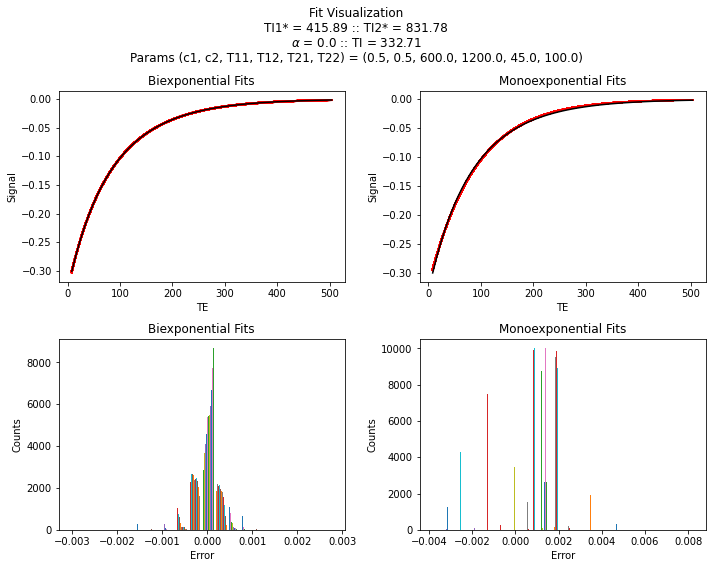

  7%|▋         | 5/71 [03:36<48:26, 44.04s/it]

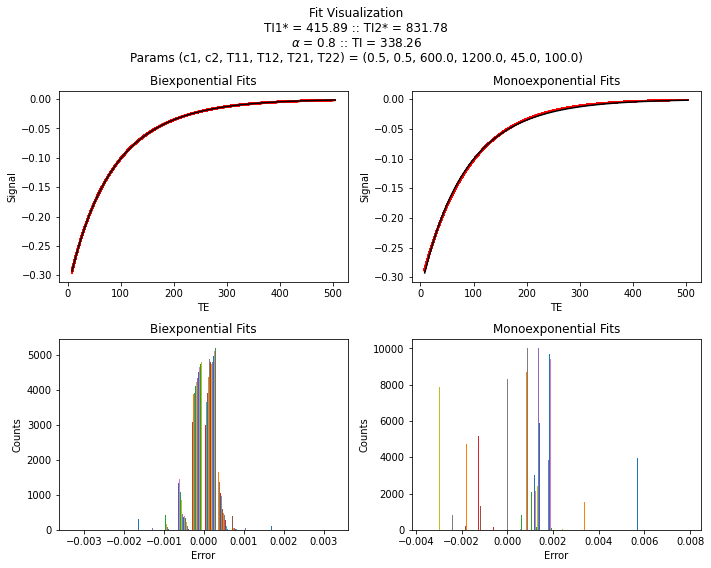

  8%|▊         | 6/71 [04:25<49:27, 45.65s/it]

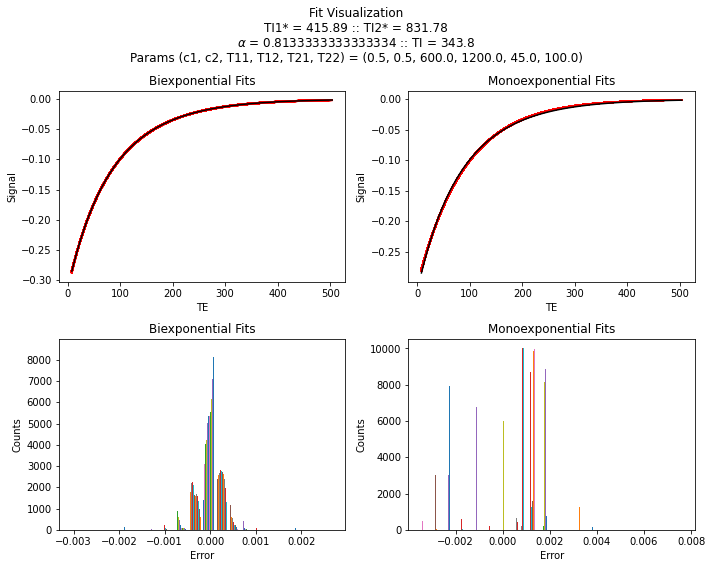

 10%|▉         | 7/71 [05:13<49:34, 46.48s/it]

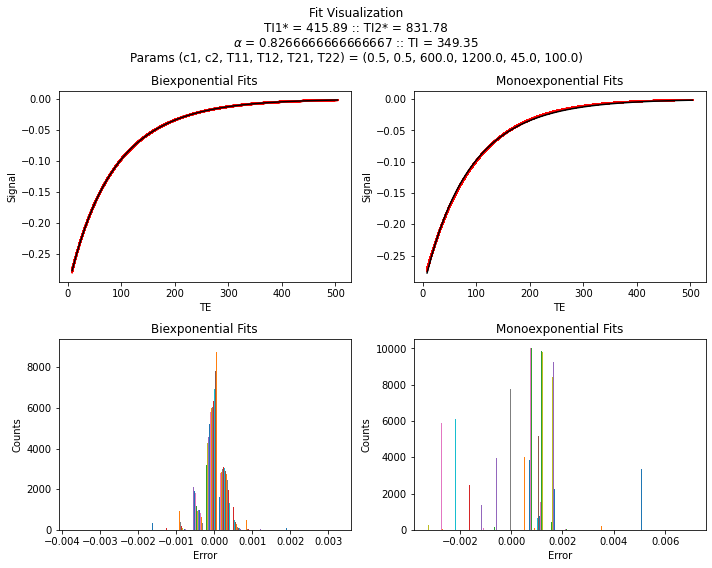

 11%|█▏        | 8/71 [05:59<48:39, 46.35s/it]

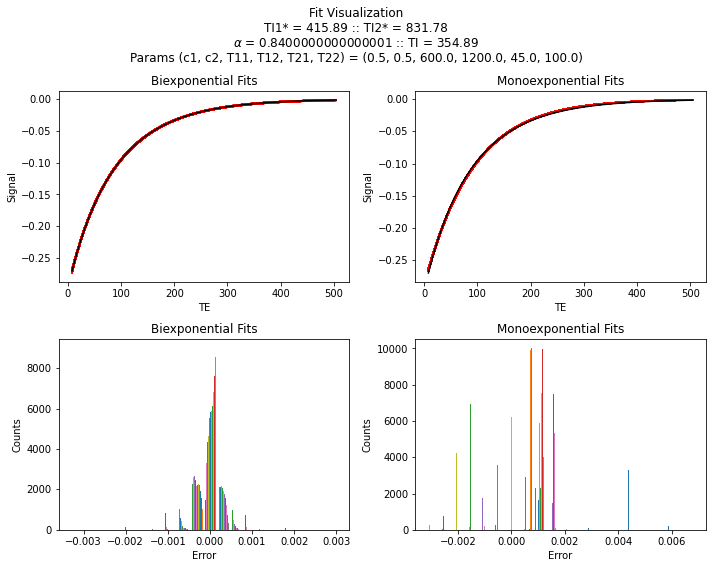

 13%|█▎        | 9/71 [06:46<47:56, 46.40s/it]

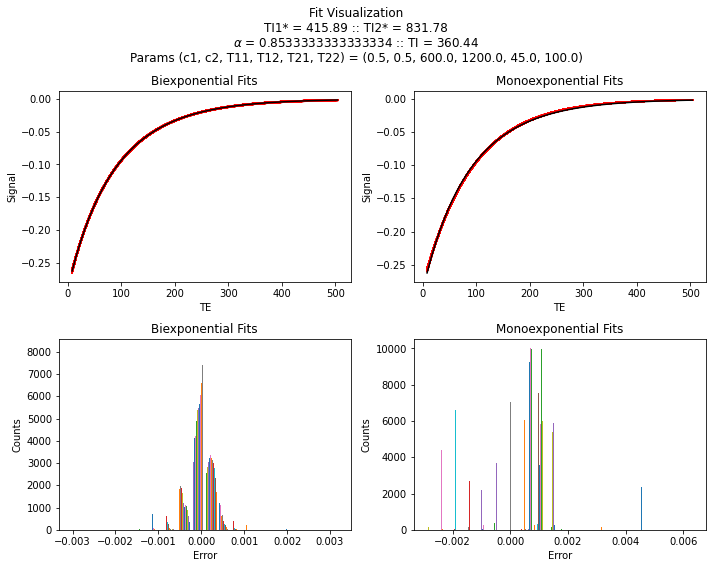

 14%|█▍        | 10/71 [07:35<48:00, 47.23s/it]

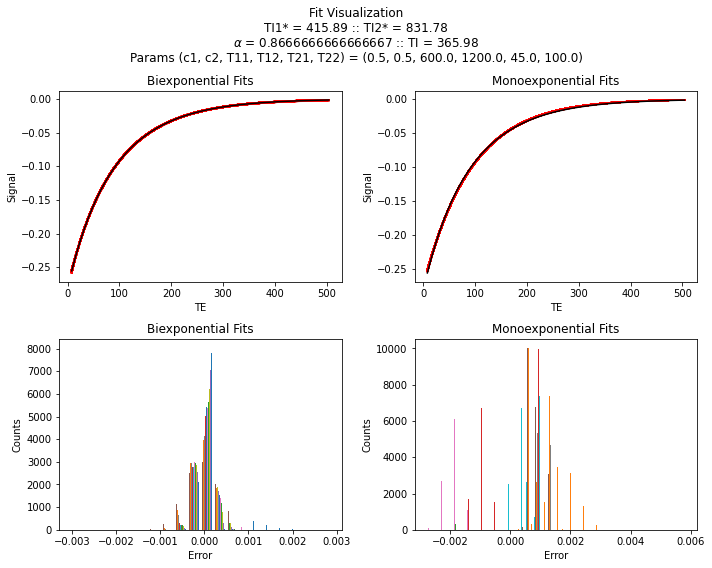

 15%|█▌        | 11/71 [08:26<48:20, 48.34s/it]

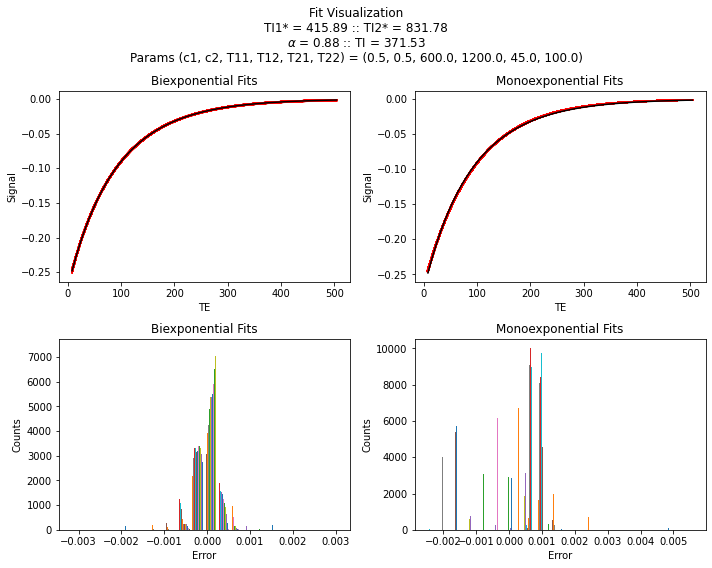

 17%|█▋        | 12/71 [09:13<47:08, 47.94s/it]

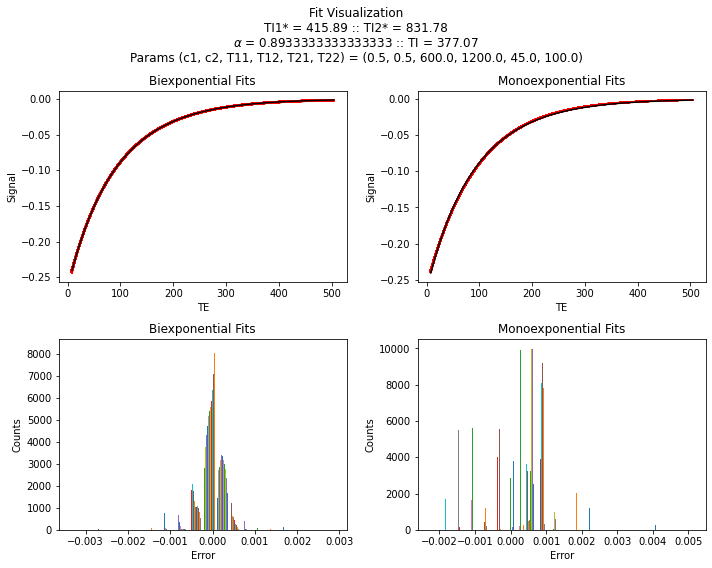

 18%|█▊        | 13/71 [10:02<46:46, 48.39s/it]

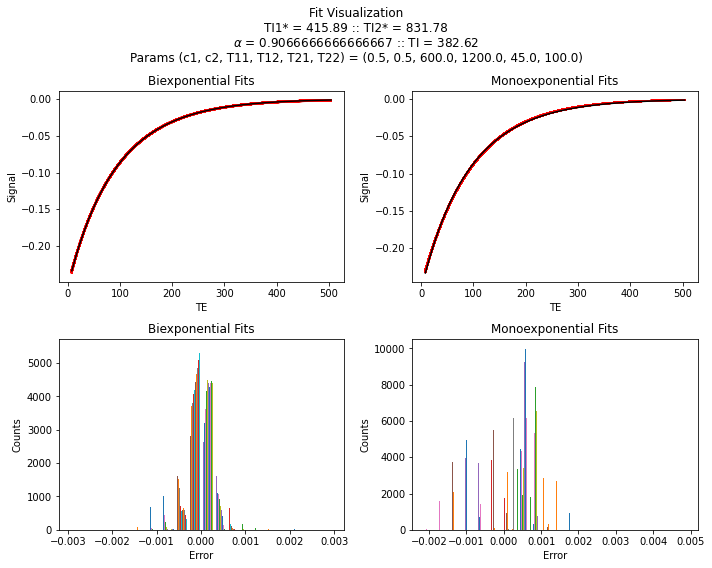

 20%|█▉        | 14/71 [10:55<47:05, 49.58s/it]

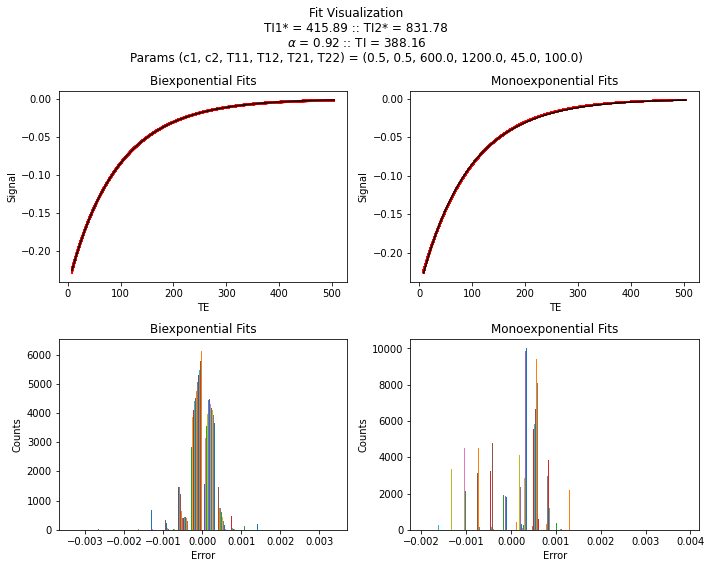

 21%|██        | 15/71 [11:53<48:43, 52.21s/it]

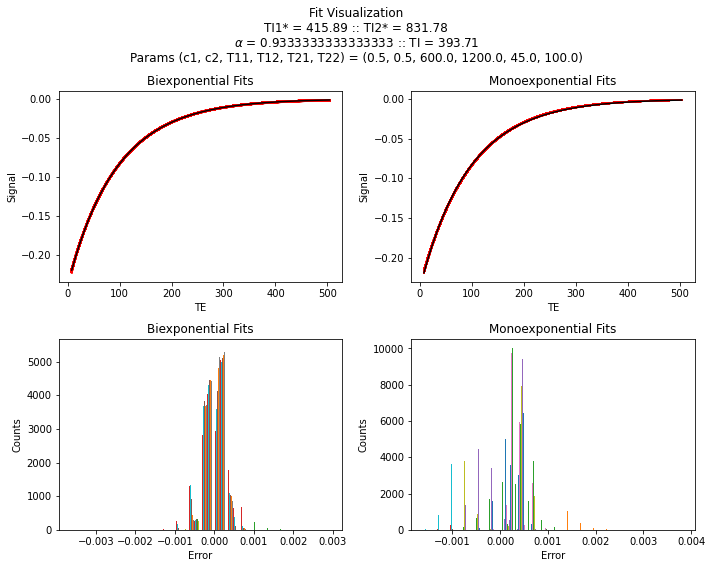

 23%|██▎       | 16/71 [13:06<53:38, 58.51s/it]

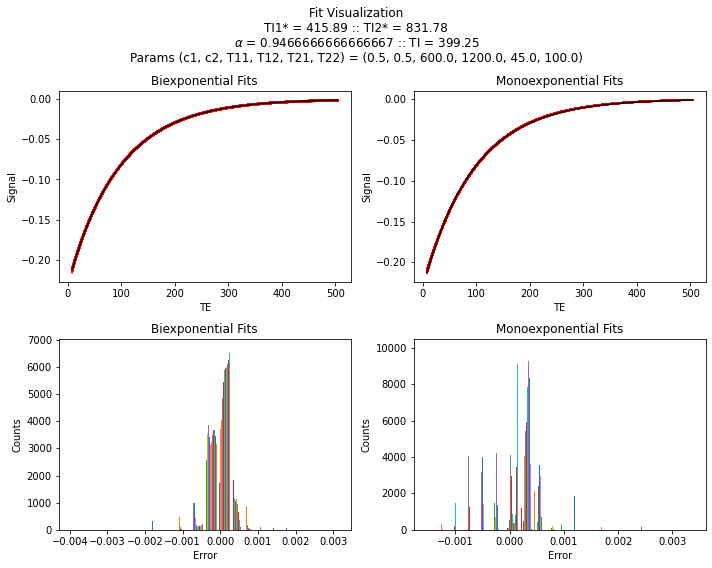

 24%|██▍       | 17/71 [14:49<1:04:49, 72.04s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4763


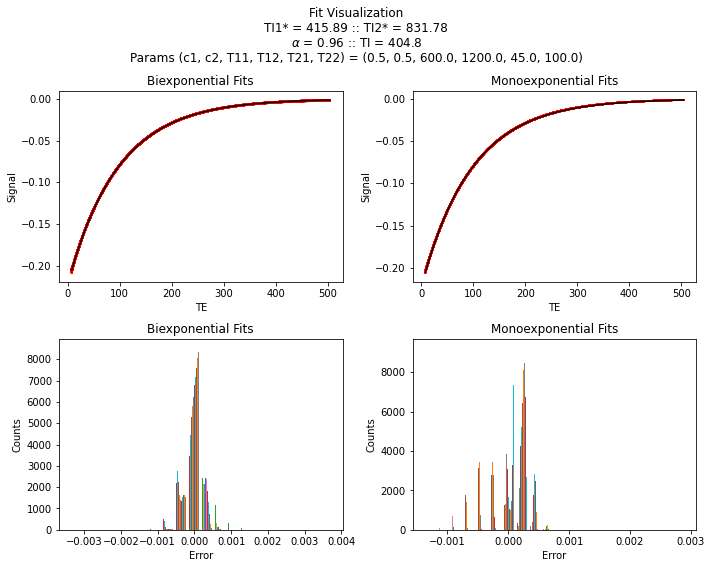

 25%|██▌       | 18/71 [17:46<1:31:27, 103.53s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 601
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 769
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1122
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2017
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2720
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3576
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7349
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8164
Optimal parameters not found: The maximum number of functi

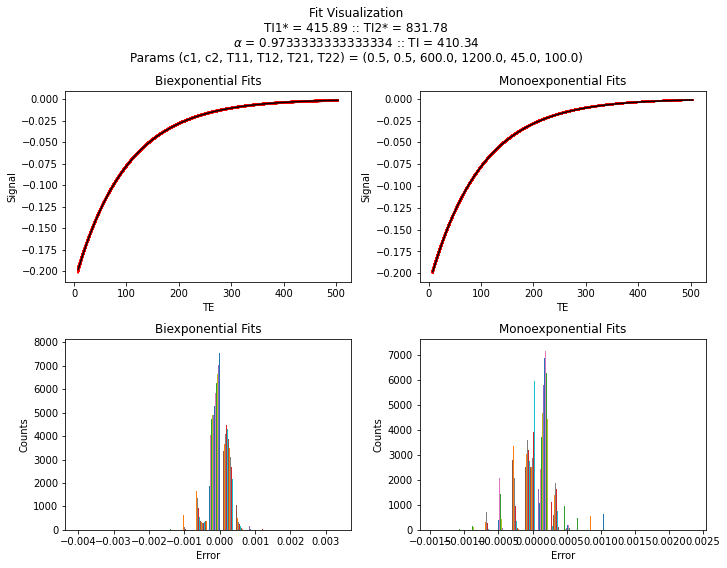

 27%|██▋       | 19/71 [21:48<2:05:38, 144.98s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 57
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 121
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 732
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 748
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1107
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1209
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1308
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2096
Optimal parameters not found: The maximum number of function 

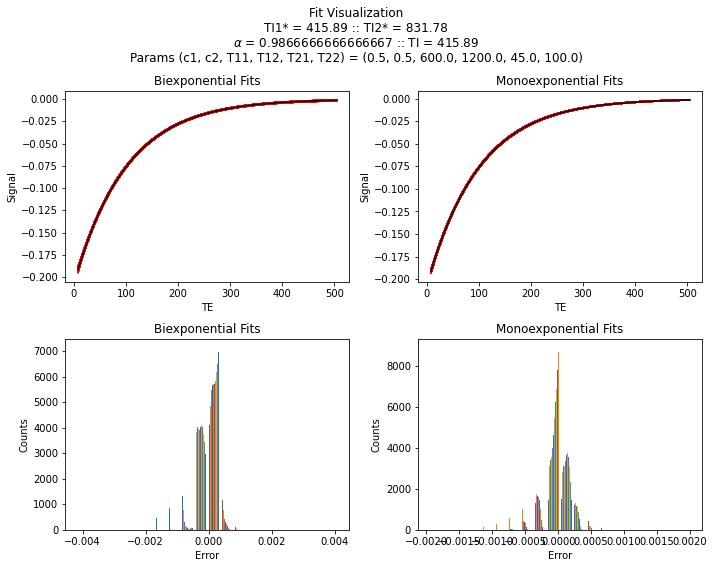

 28%|██▊       | 20/71 [27:04<2:46:59, 196.45s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 79
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 99
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 173
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 238
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 269
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 311
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 365
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 676
Optimal parameters not found: The maximum number of function evalu

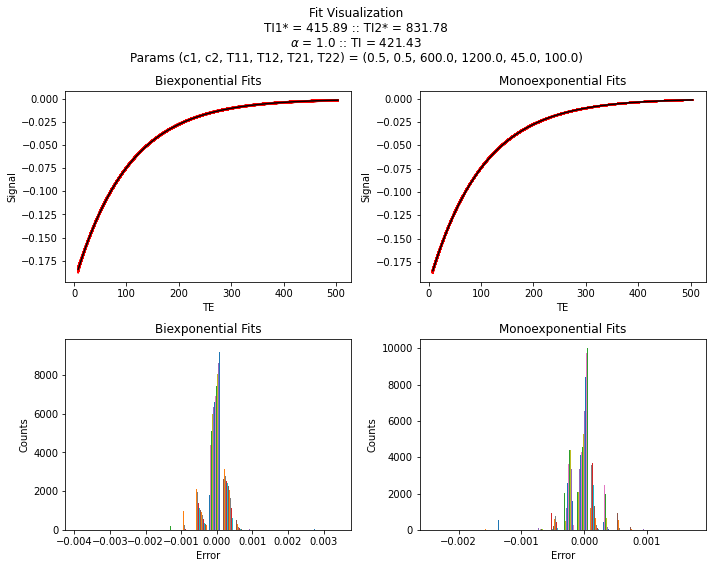

 30%|██▉       | 21/71 [32:59<3:23:12, 243.85s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 78
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 111
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 221
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 320
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 433
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 441
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 638
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 691
Optimal parameters not found: The maximum number of function eval

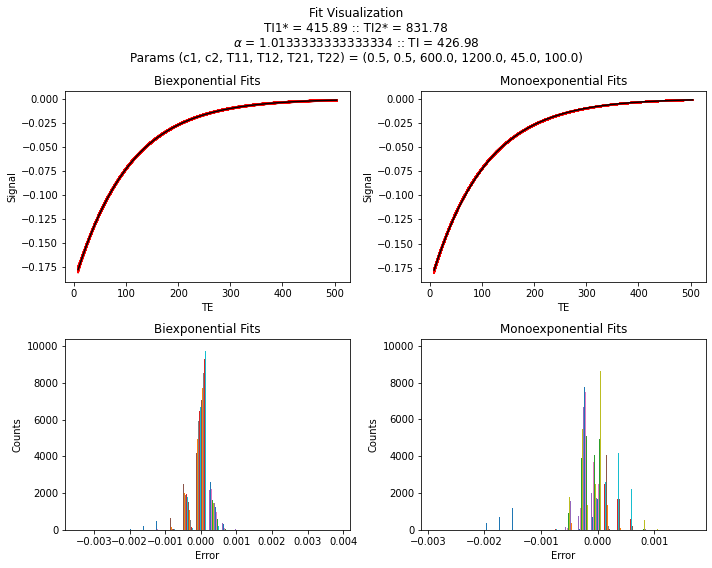

 31%|███       | 22/71 [38:48<3:44:59, 275.50s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 18
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 245
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 425
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 475
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 564
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 578
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 645
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 660
Optimal parameters not found: The maximum number of function eval

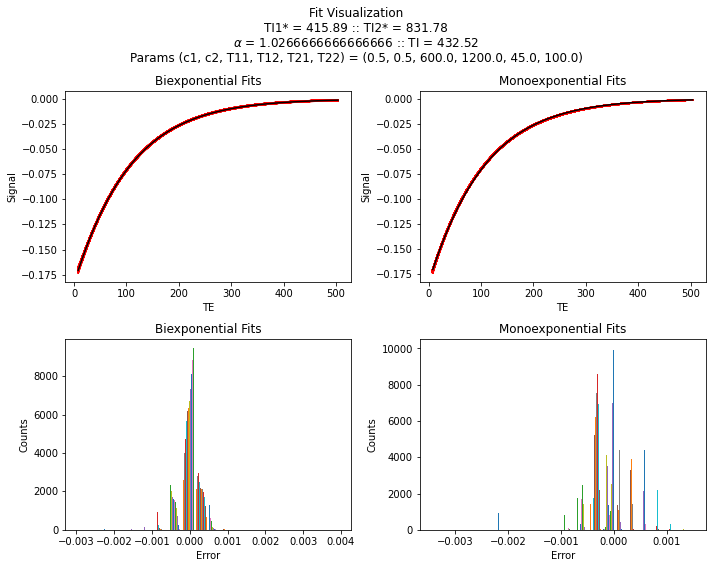

 32%|███▏      | 23/71 [43:00<3:34:51, 268.57s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 96
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 155
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 281
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 405
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 494
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 531
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 643
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 649
Optimal parameters not found: The maximum number of function eval

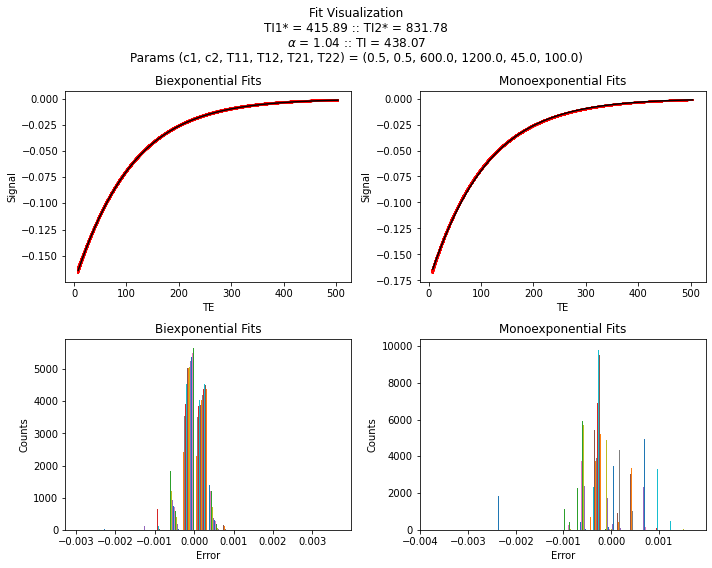

 34%|███▍      | 24/71 [46:28<3:16:02, 250.27s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 11
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 288
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 583
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 793
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 904
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1058
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1097
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1177
Optimal parameters not found: The maximum number of function e

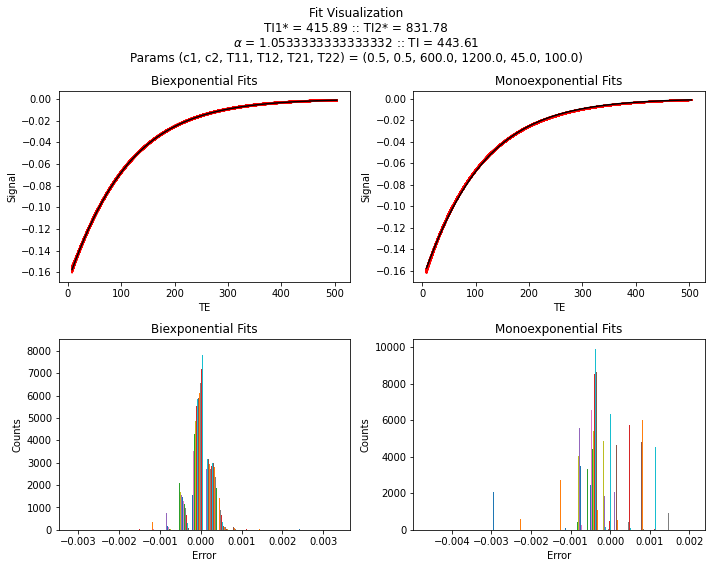

 35%|███▌      | 25/71 [49:13<2:52:13, 224.64s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 167
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 829
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 877
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1023
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1179
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1320
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1370
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1632
Optimal parameters not found: The maximum number of functio

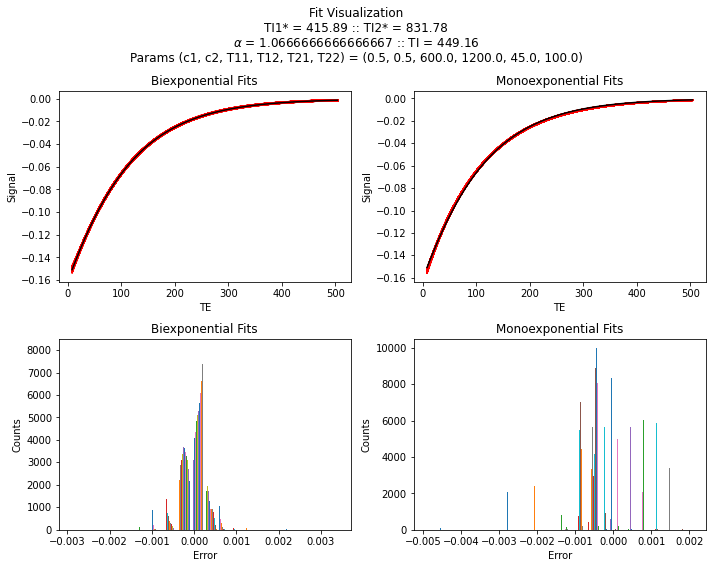

 37%|███▋      | 26/71 [51:53<2:34:04, 205.44s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 94
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 499
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1340
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1509
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1770
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1956
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2180
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3202
Optimal parameters not found: The maximum number of functio

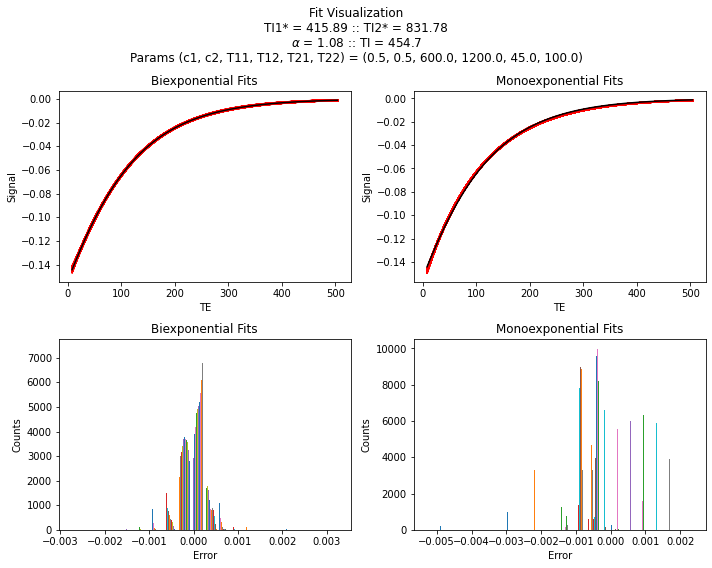

 38%|███▊      | 27/71 [54:20<2:17:43, 187.80s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 680
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 739
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1200
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1476
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2655
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3064
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3340
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 6238
Optimal parameters not found: The maximum number of functi

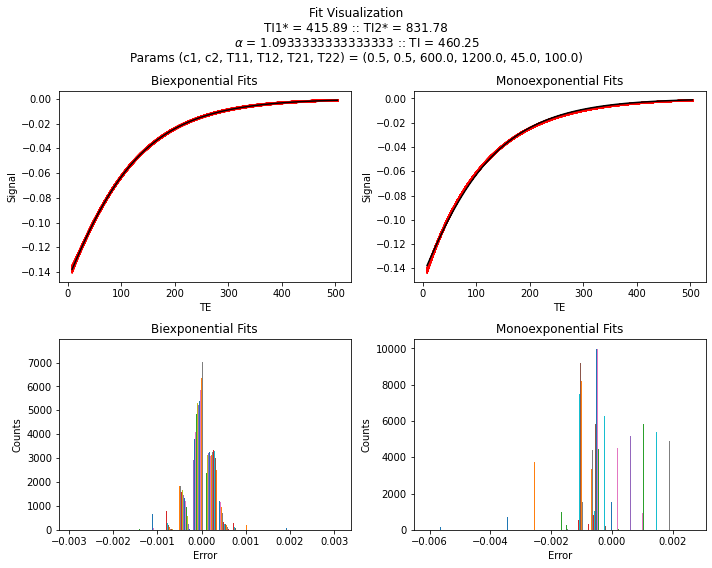

 39%|███▉      | 28/71 [56:17<1:59:24, 166.62s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 524
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 536
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2351
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8692
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9101
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9231
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9553
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9998


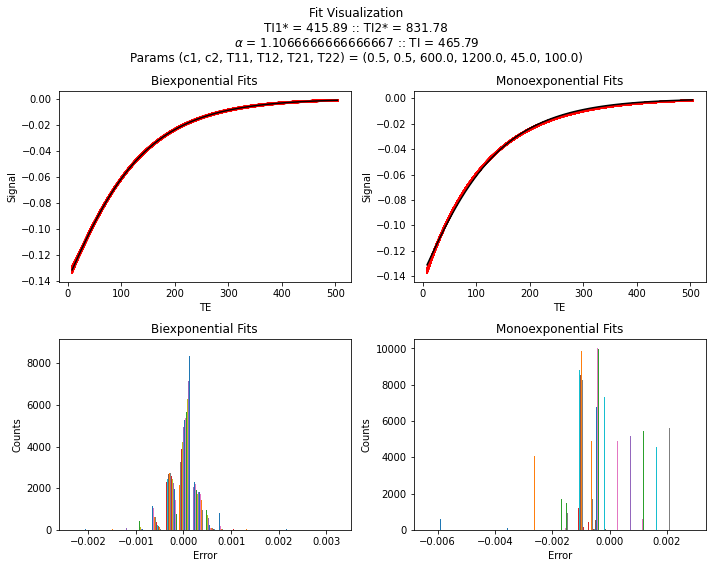

 41%|████      | 29/71 [57:59<1:43:02, 147.21s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3394
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3972
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4226
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4528
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9847


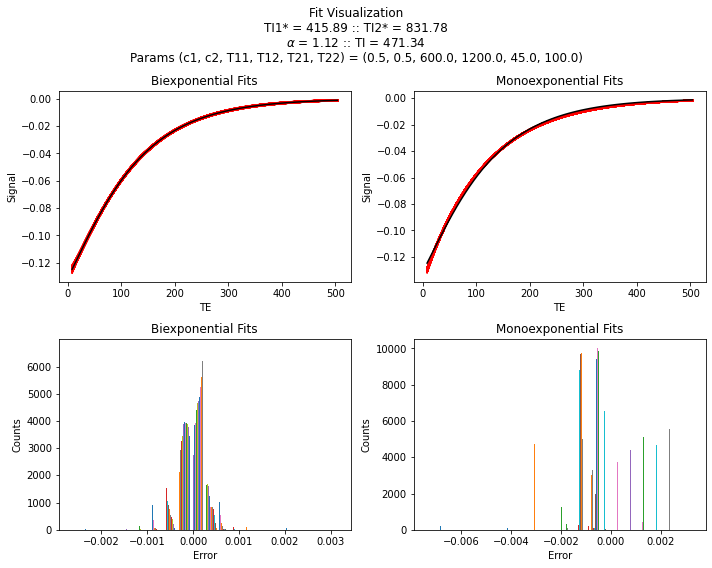

 42%|████▏     | 30/71 [59:25<1:27:58, 128.75s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1076
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1130


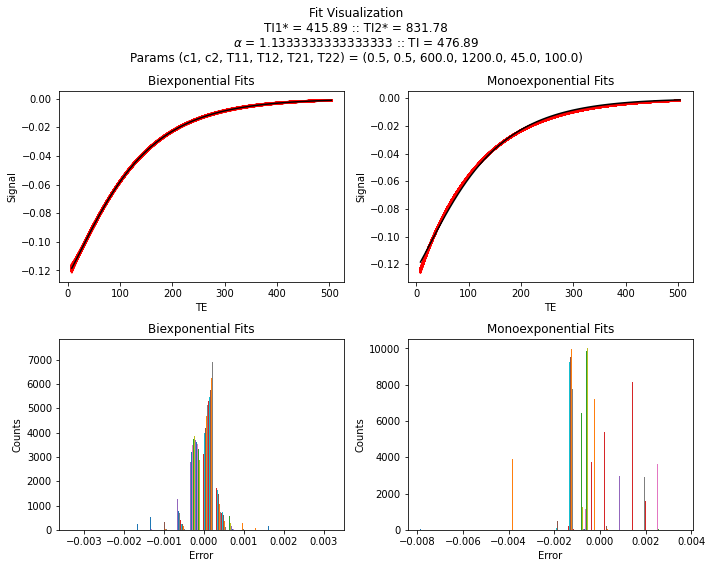

 44%|████▎     | 31/71 [1:00:55<1:18:03, 117.08s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5918


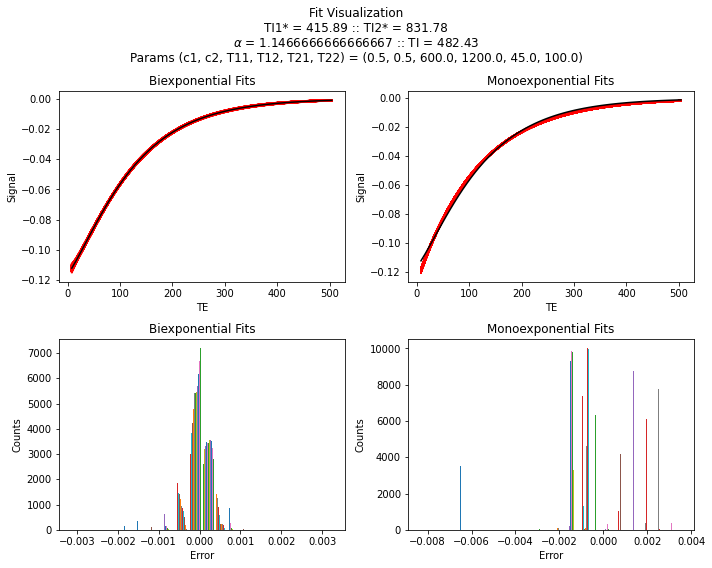

 45%|████▌     | 32/71 [1:02:24<1:10:39, 108.70s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5388


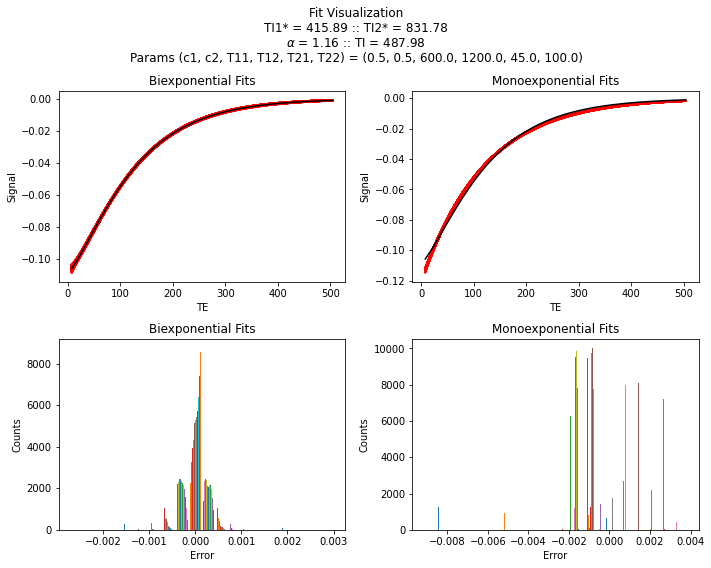

 46%|████▋     | 33/71 [1:03:52<1:04:59, 102.63s/it]

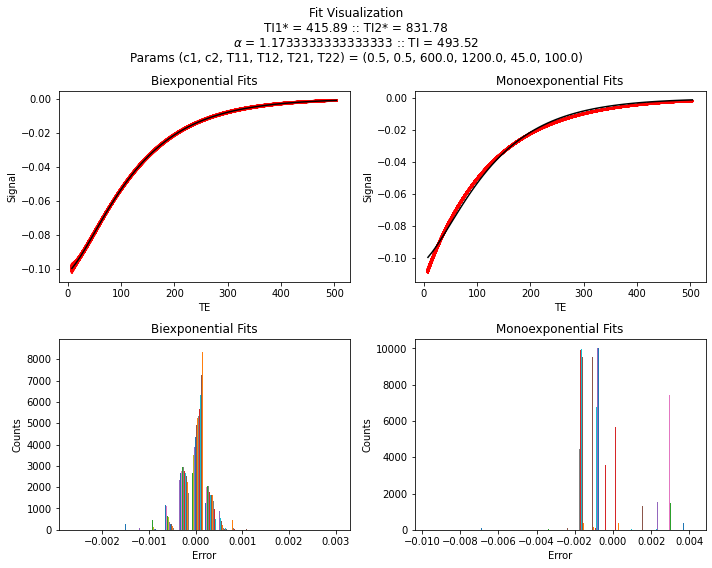

 48%|████▊     | 34/71 [1:05:15<59:36, 96.65s/it]   

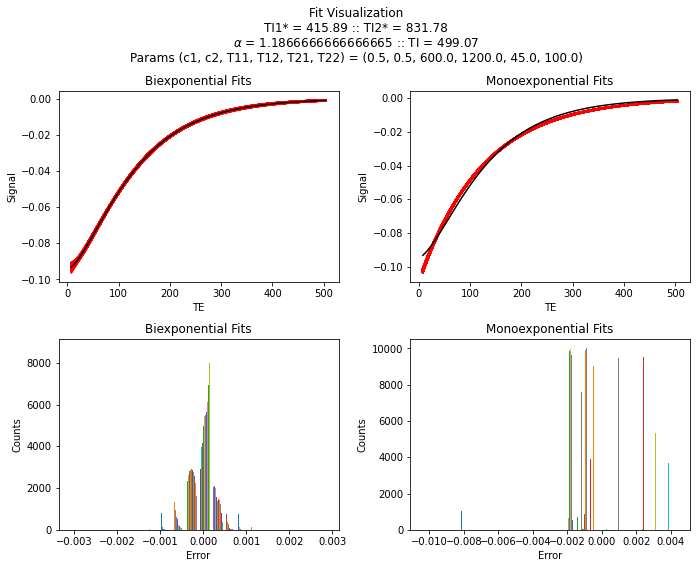

 49%|████▉     | 35/71 [1:06:35<55:02, 91.72s/it]

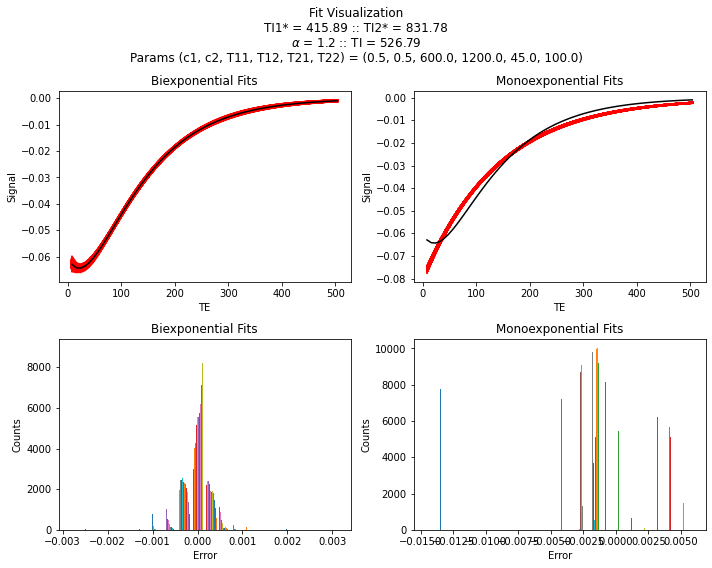

 51%|█████     | 36/71 [1:07:46<49:47, 85.35s/it]

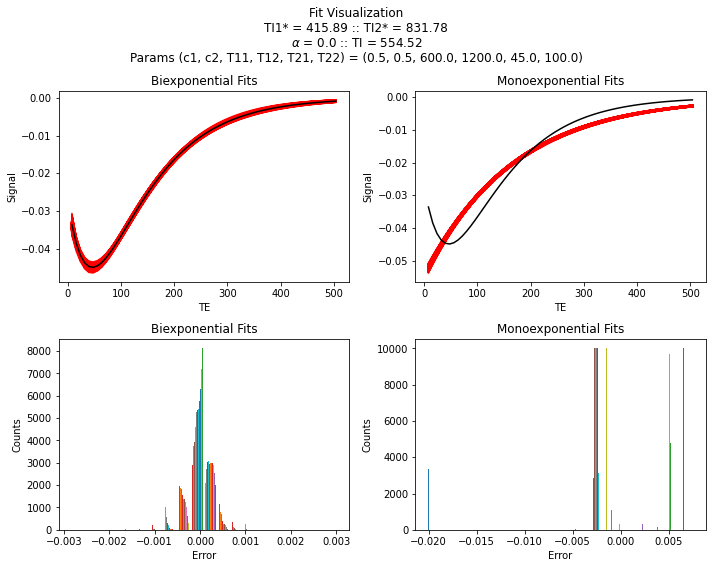

 52%|█████▏    | 37/71 [1:08:56<45:45, 80.75s/it]

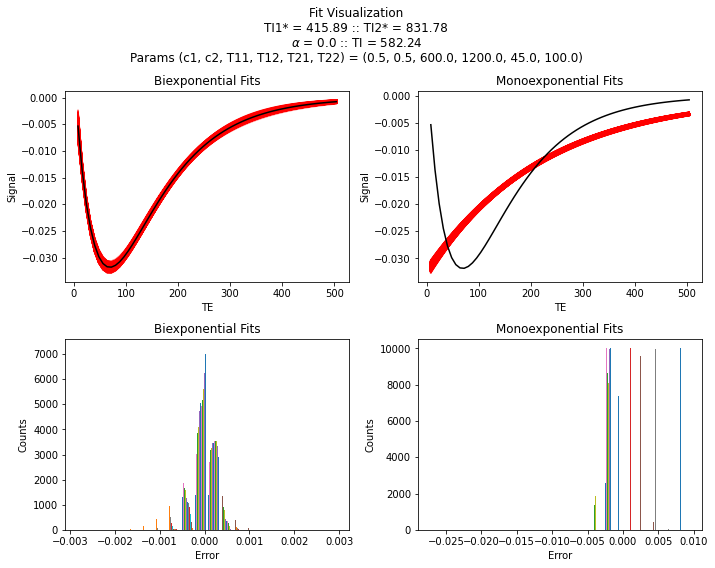

 54%|█████▎    | 38/71 [1:10:22<45:18, 82.38s/it]

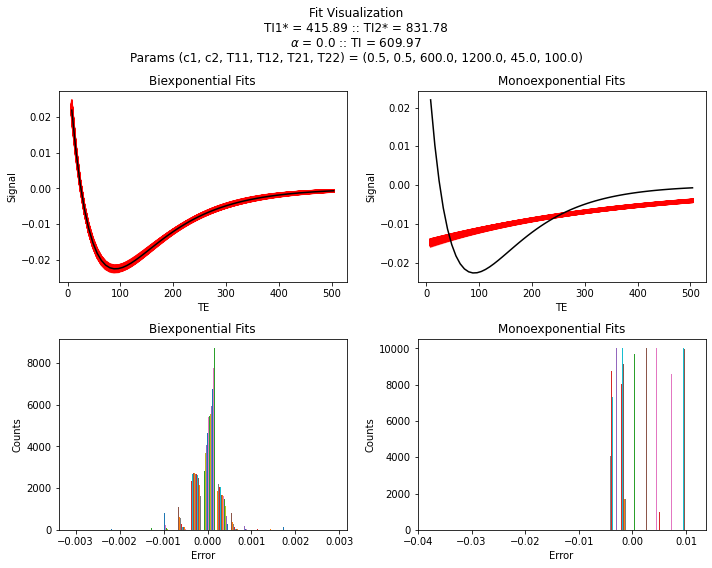

 55%|█████▍    | 39/71 [1:12:06<47:20, 88.76s/it]

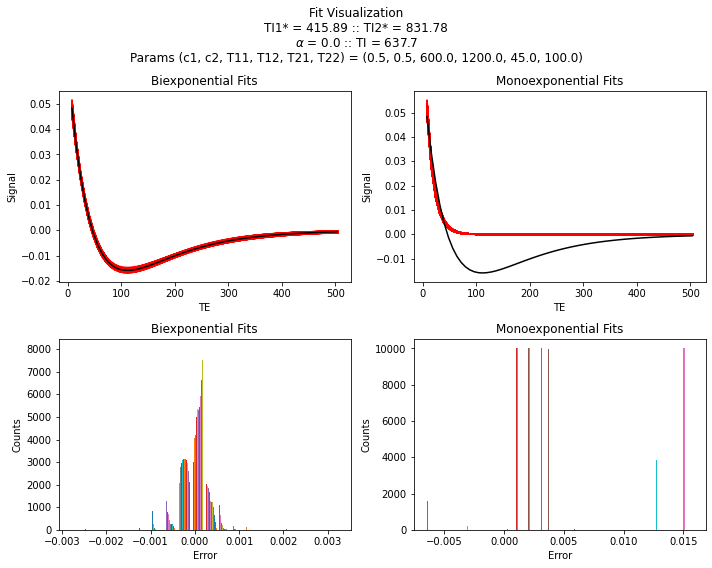

 56%|█████▋    | 40/71 [1:13:48<47:56, 92.80s/it]

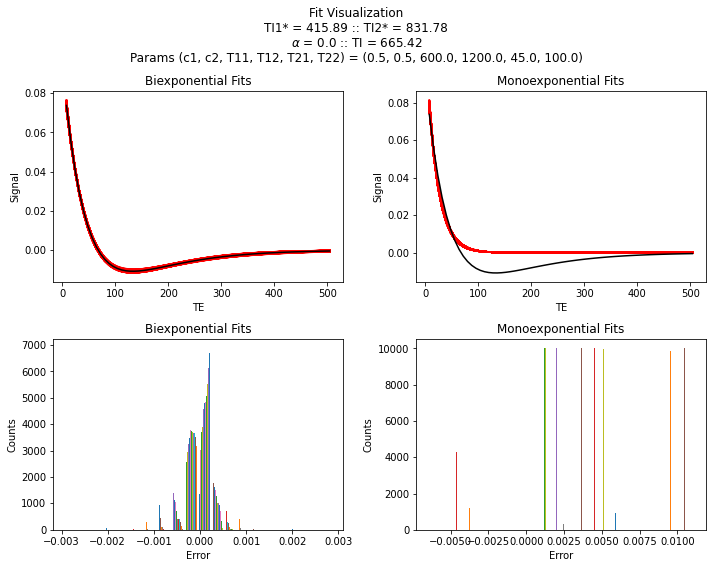

 58%|█████▊    | 41/71 [1:15:16<45:41, 91.39s/it]

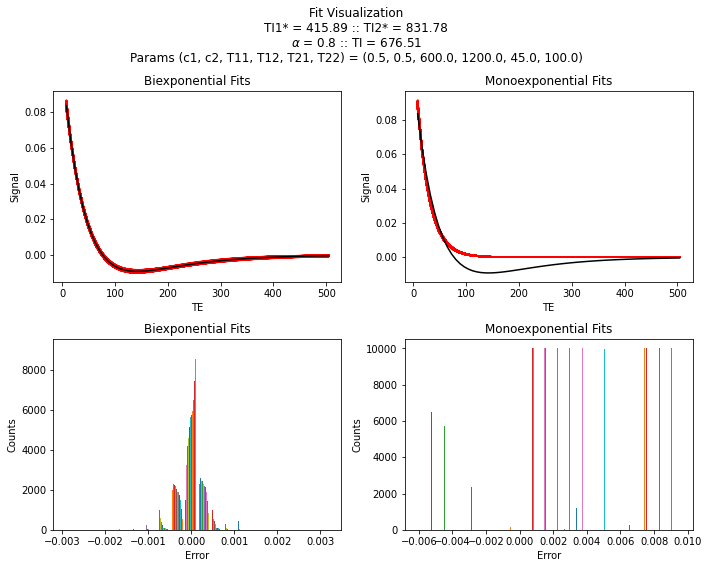

 59%|█████▉    | 42/71 [1:16:32<41:59, 86.87s/it]

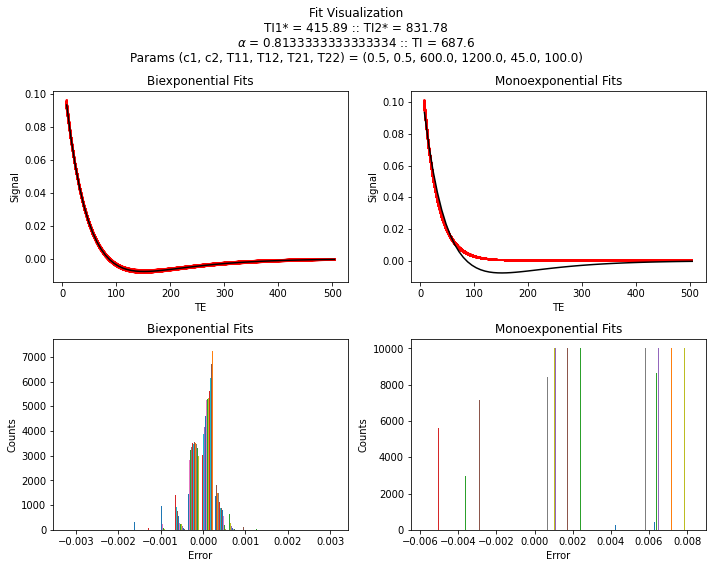

 61%|██████    | 43/71 [1:17:28<36:13, 77.61s/it]

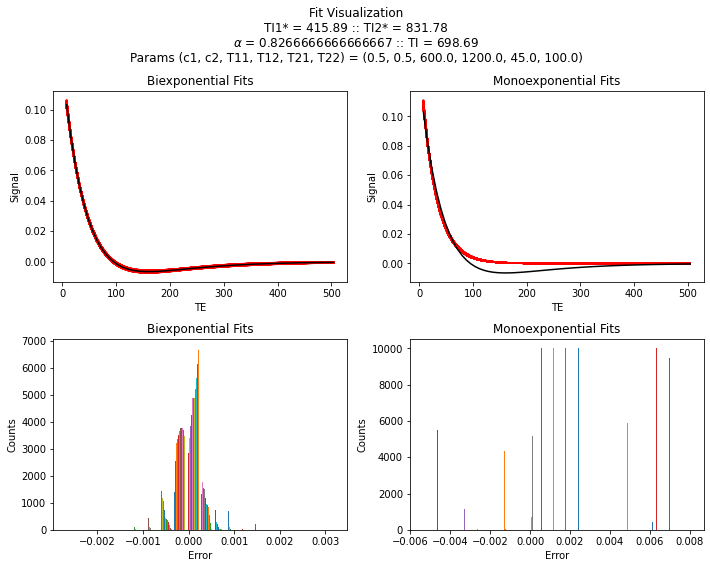

 62%|██████▏   | 44/71 [1:18:24<31:55, 70.93s/it]

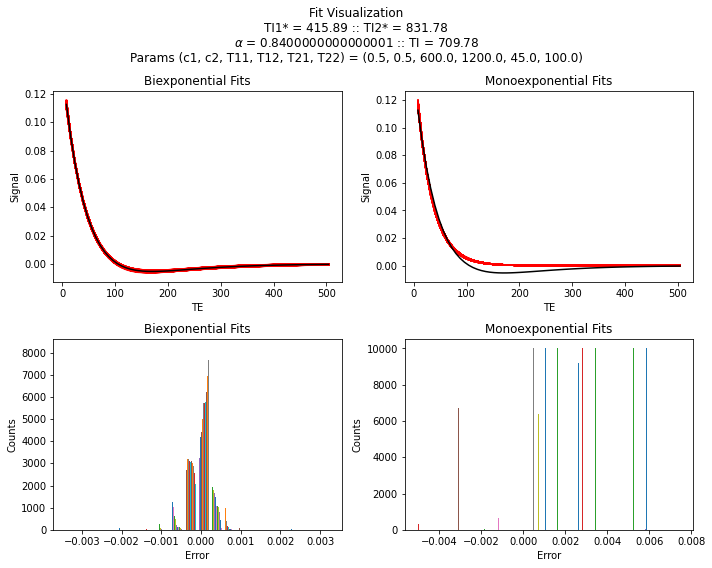

 63%|██████▎   | 45/71 [1:19:18<28:32, 65.85s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1201


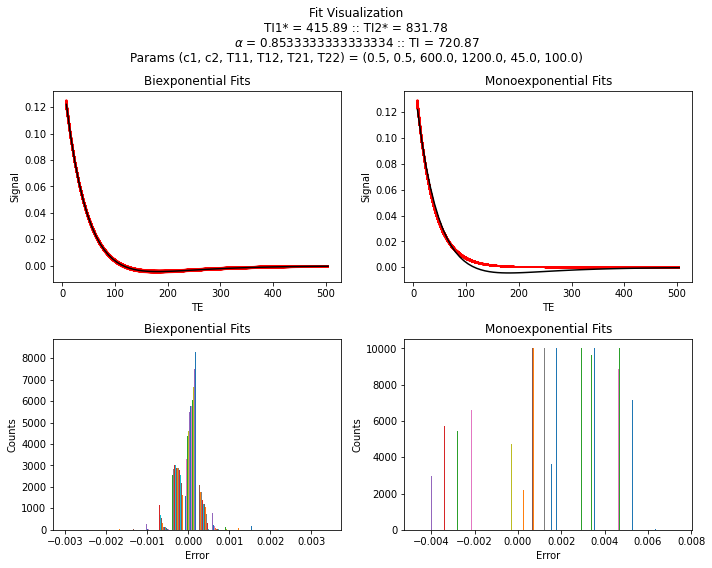

 65%|██████▍   | 46/71 [1:20:13<26:10, 62.81s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8133


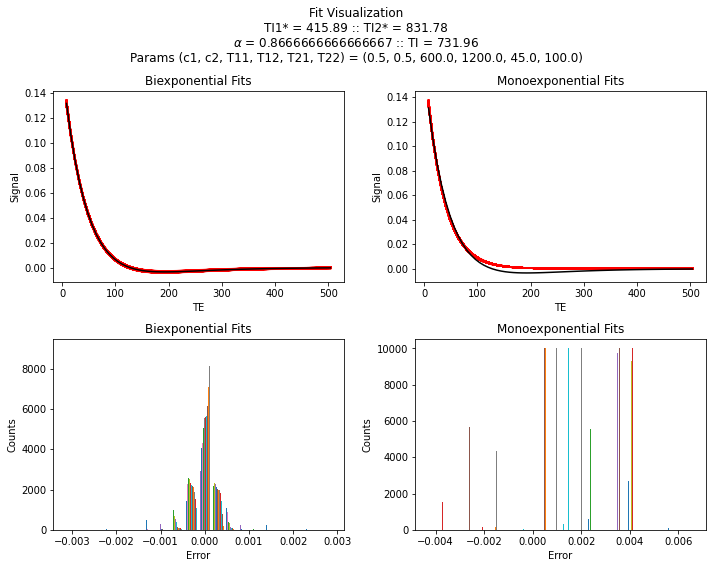

 66%|██████▌   | 47/71 [1:21:13<24:42, 61.79s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3641
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 6706


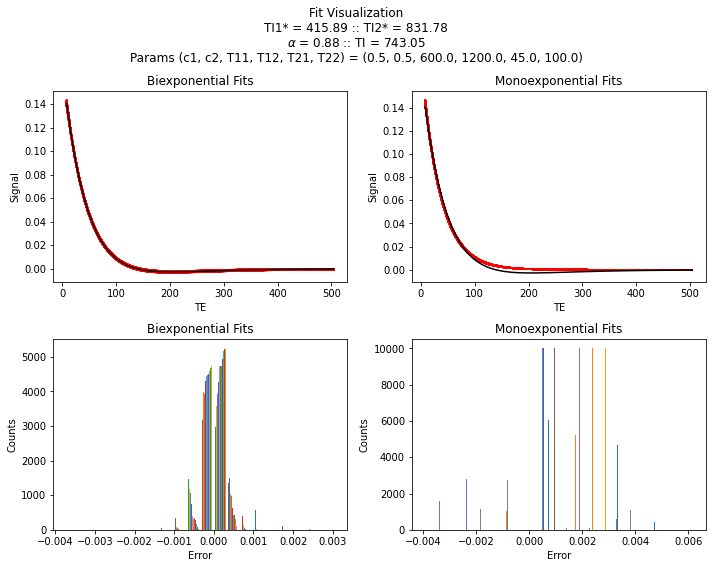

 68%|██████▊   | 48/71 [1:22:15<23:43, 61.88s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1940
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3969


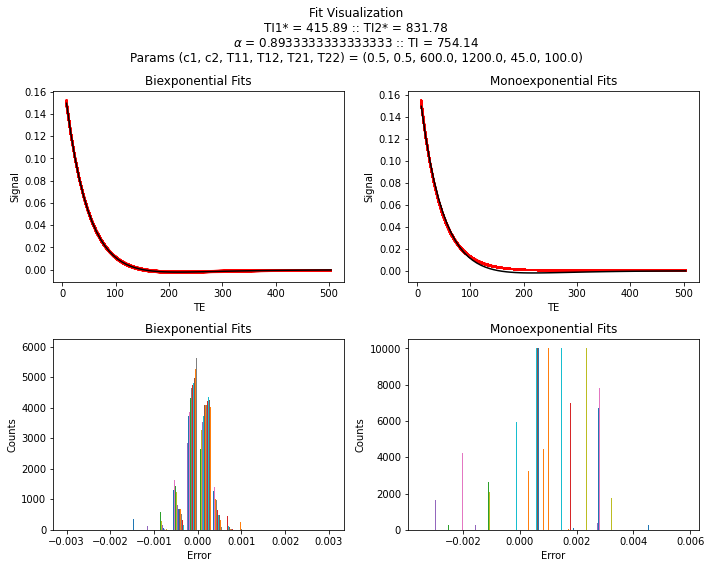

 69%|██████▉   | 49/71 [1:23:24<23:31, 64.18s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1192
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1509
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1795
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1939
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2806
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4086
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 6240
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 6527
Optimal parameters not found: The maximum number of func

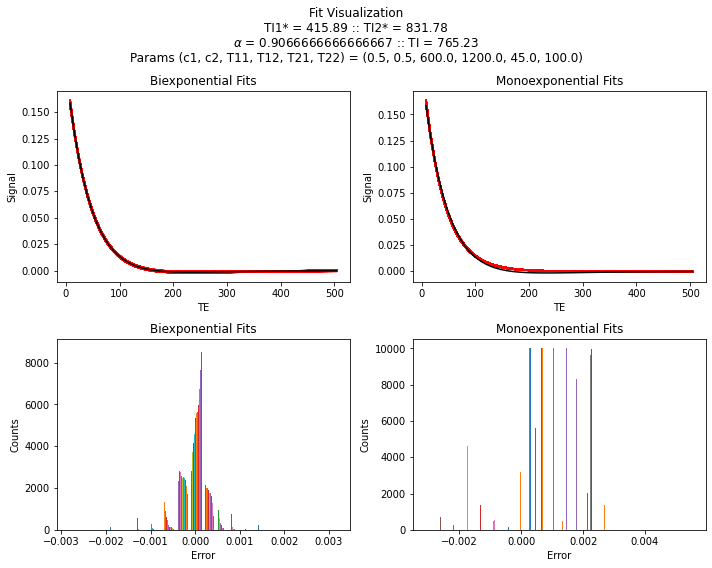

 70%|███████   | 50/71 [1:24:44<24:07, 68.90s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 851
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1045
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2703
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3350
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4264
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5586
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 6361
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8001
Optimal parameters not found: The maximum number of funct

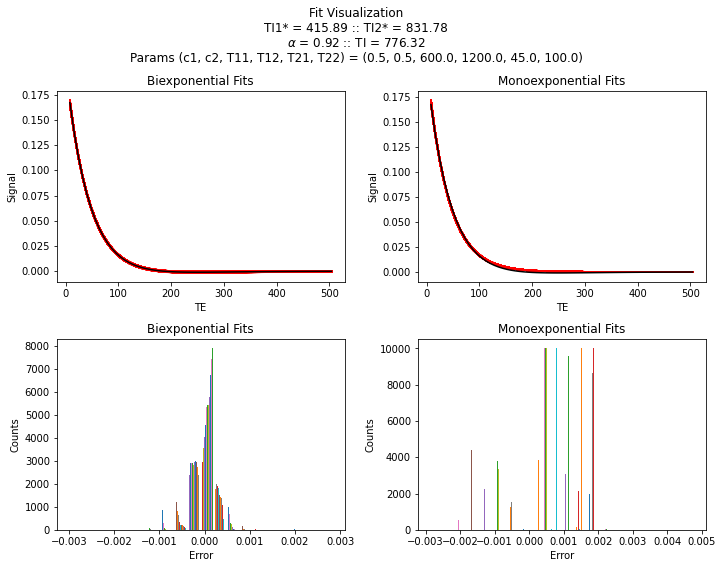

 72%|███████▏  | 51/71 [1:26:16<25:16, 75.84s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 380
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 831
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 892
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1240
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1257
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1493
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2025
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2130
Optimal parameters not found: The maximum number of functio

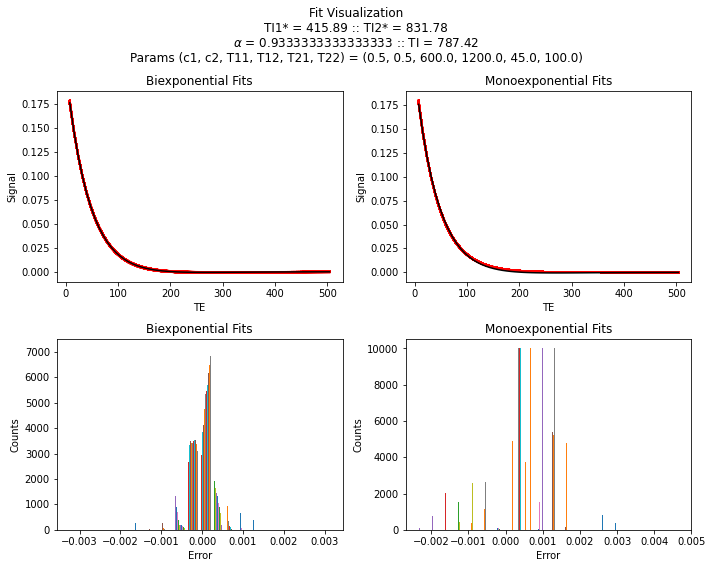

 73%|███████▎  | 52/71 [1:28:12<27:50, 87.92s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 607
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 955
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1390
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1429
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1742
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1982
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2321
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2497
Optimal parameters not found: The maximum number of functi

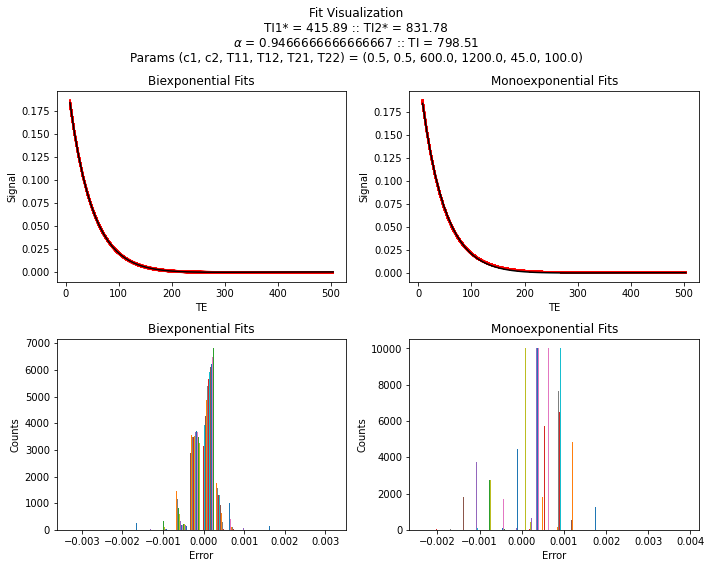

 75%|███████▍  | 53/71 [1:30:36<31:21, 104.55s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 120
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 221
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 243
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 761
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 929
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1273
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1800
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2235
Optimal parameters not found: The maximum number of function 

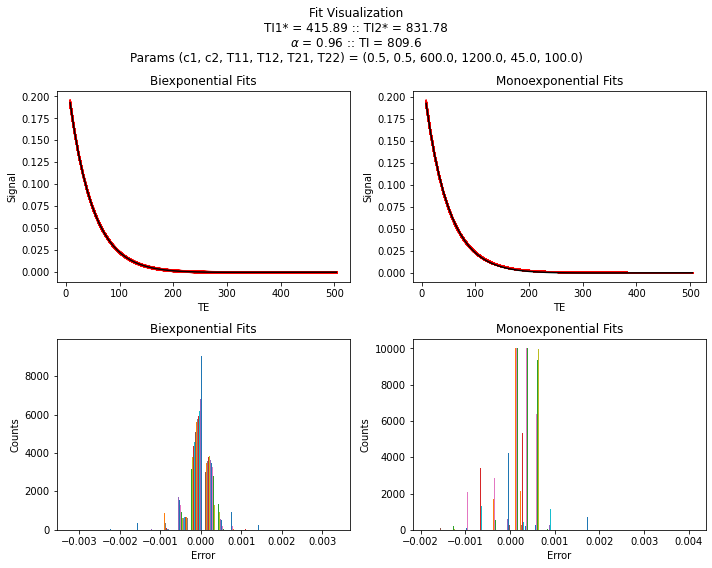

 76%|███████▌  | 54/71 [1:34:13<39:10, 138.26s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 186
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 257
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 416
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 719
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1815
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2325
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2581
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3376
Optimal parameters not found: The maximum number of function

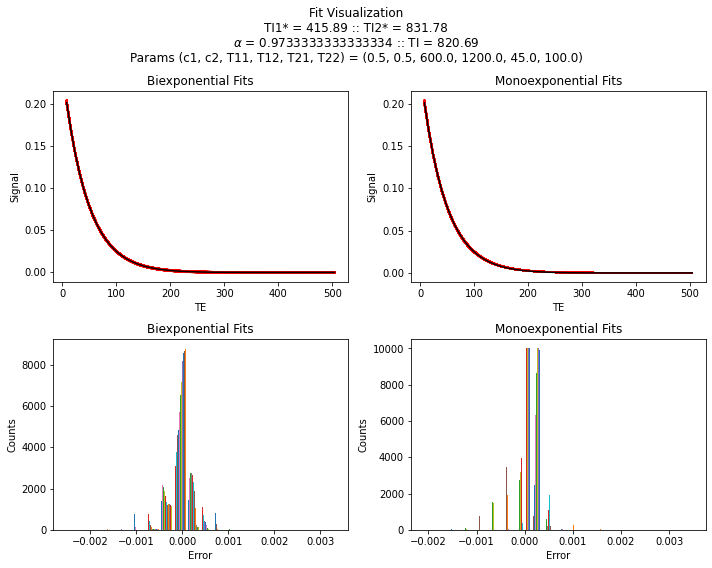

 77%|███████▋  | 55/71 [1:38:15<45:11, 169.45s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 291
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 6384
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7227
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7609
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7734
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9113
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9405
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9754


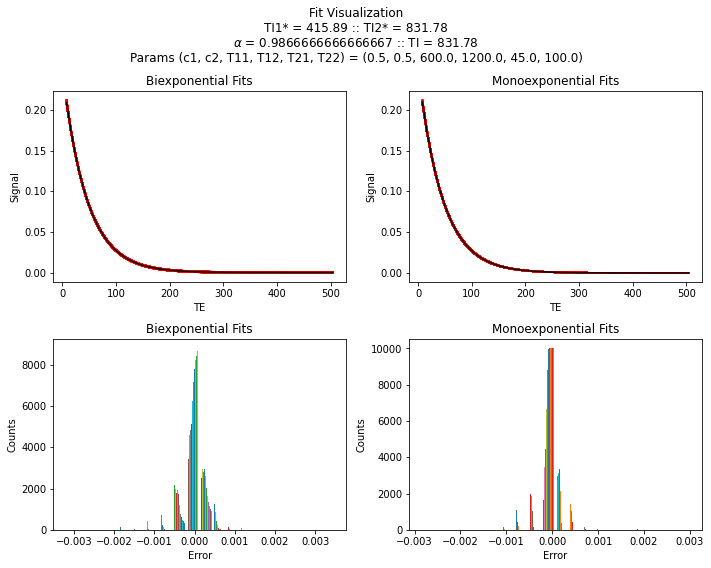

 79%|███████▉  | 56/71 [1:41:38<44:52, 179.53s/it]

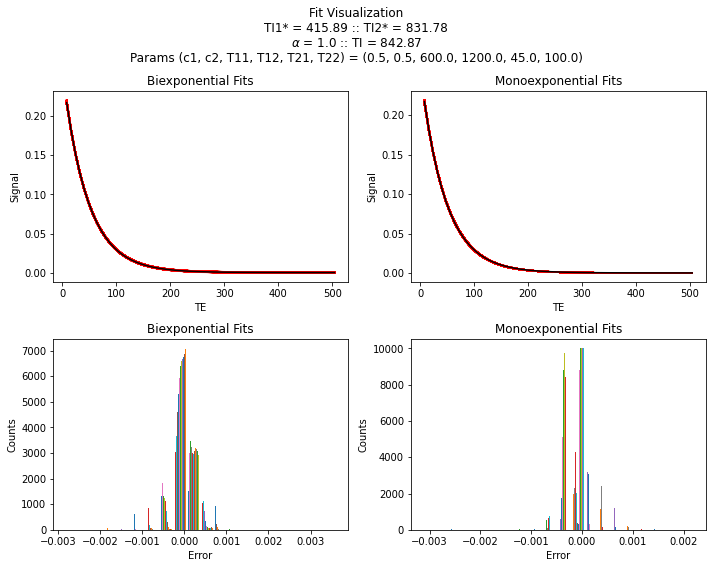

 80%|████████  | 57/71 [1:43:31<37:13, 159.55s/it]

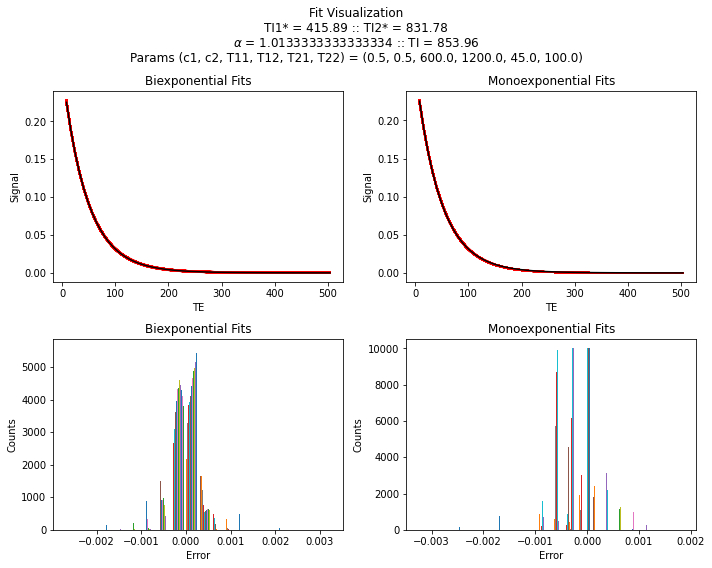

 82%|████████▏ | 58/71 [1:44:58<29:53, 137.95s/it]

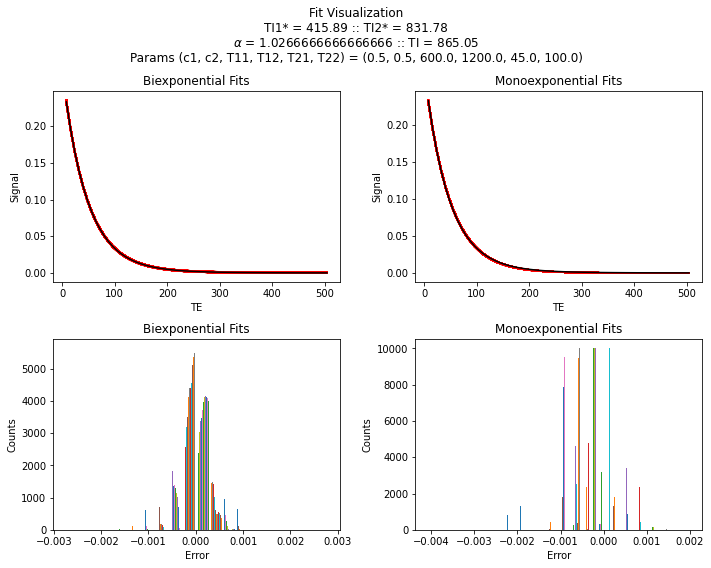

 83%|████████▎ | 59/71 [1:46:16<23:56, 119.73s/it]

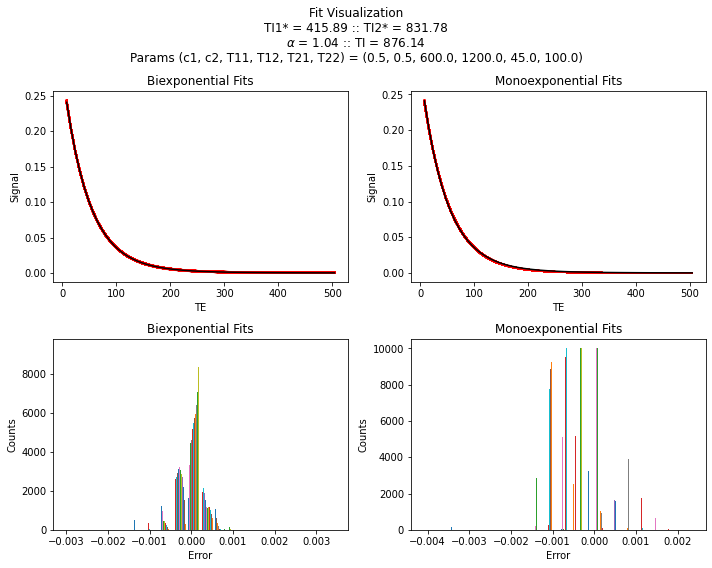

 85%|████████▍ | 60/71 [1:47:16<18:39, 101.81s/it]

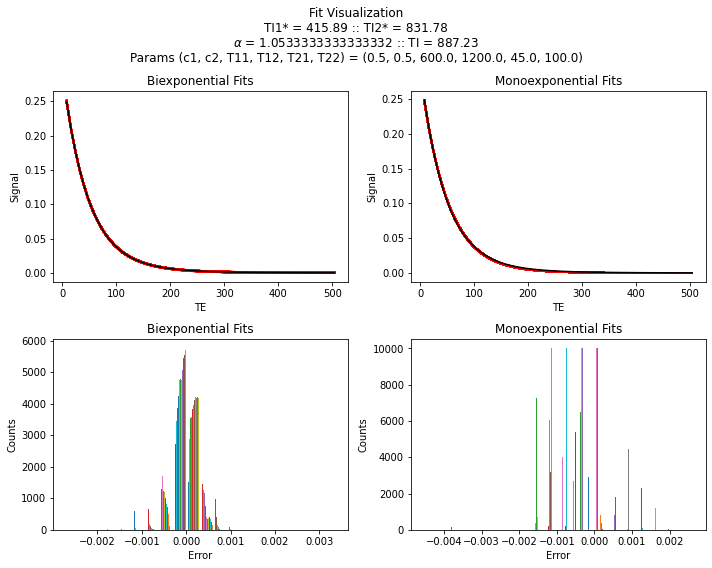

 86%|████████▌ | 61/71 [1:48:19<15:04, 90.40s/it] 

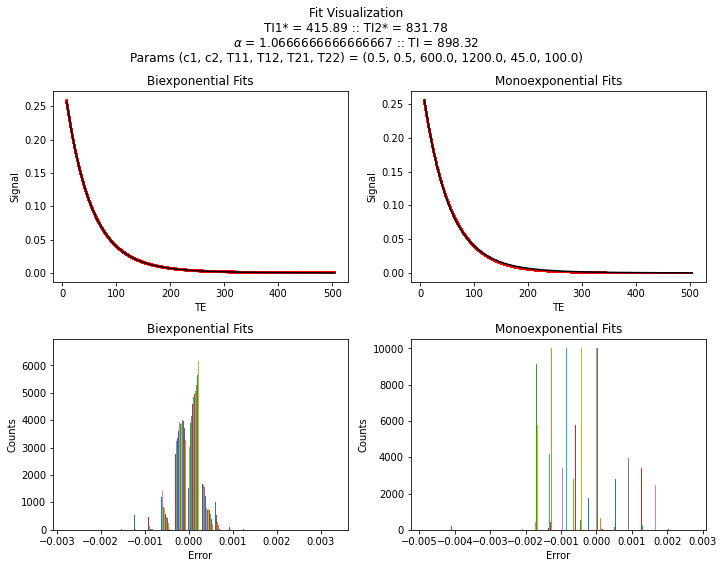

 87%|████████▋ | 62/71 [1:49:29<12:37, 84.21s/it]

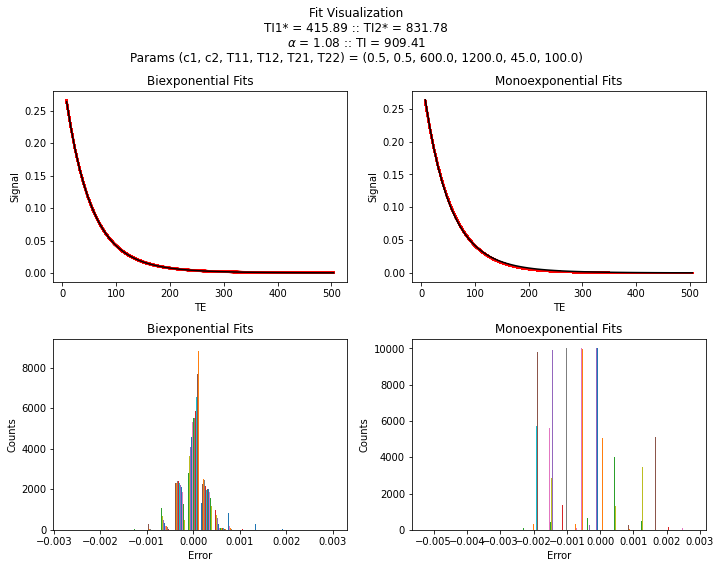

 89%|████████▊ | 63/71 [1:50:32<10:21, 77.75s/it]

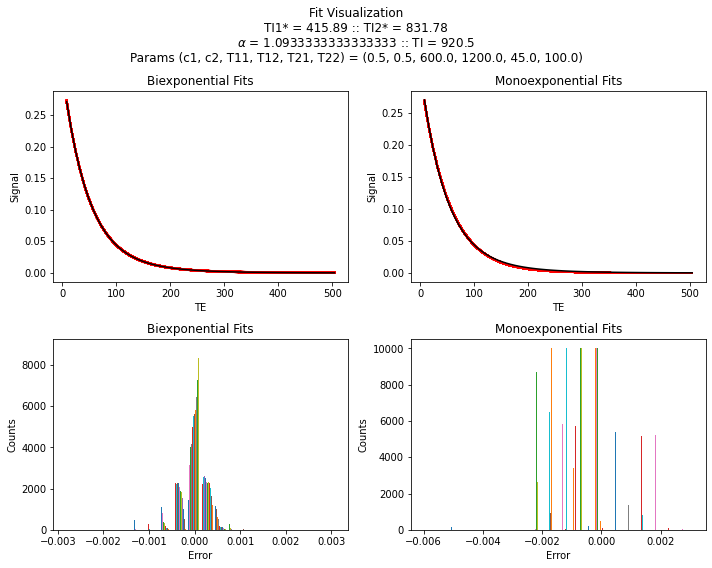

 90%|█████████ | 64/71 [1:51:30<08:22, 71.83s/it]

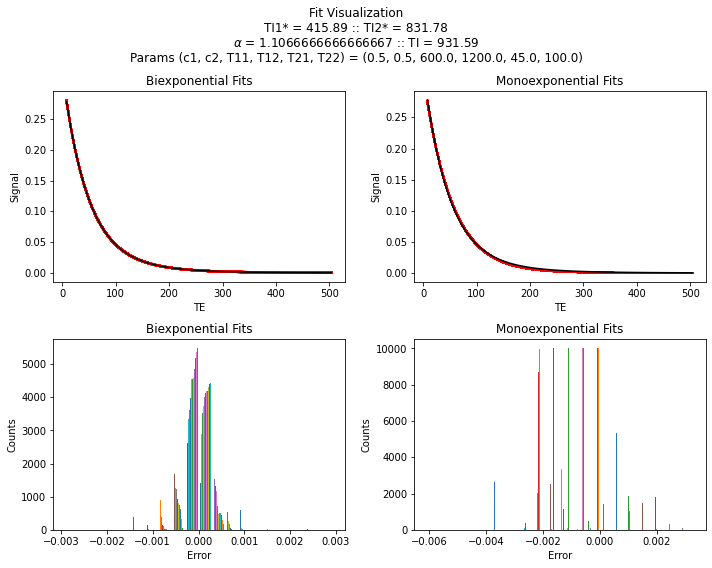

 92%|█████████▏| 65/71 [1:52:26<06:42, 67.15s/it]

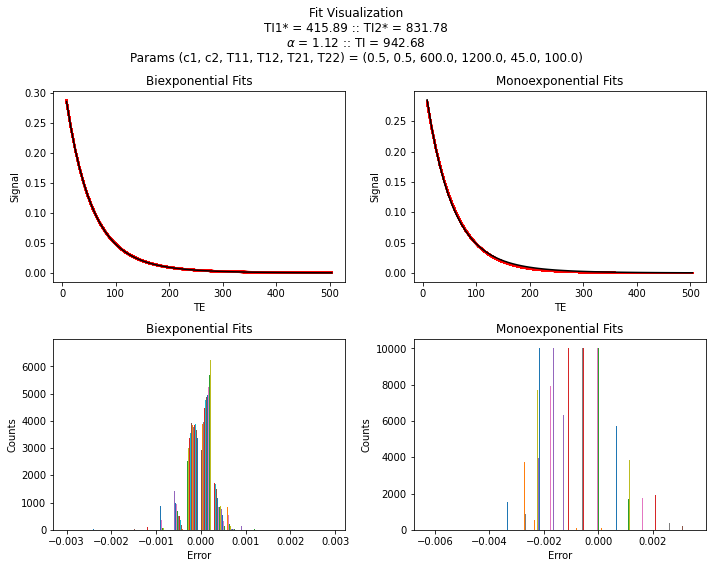

 93%|█████████▎| 66/71 [1:53:19<05:14, 62.97s/it]

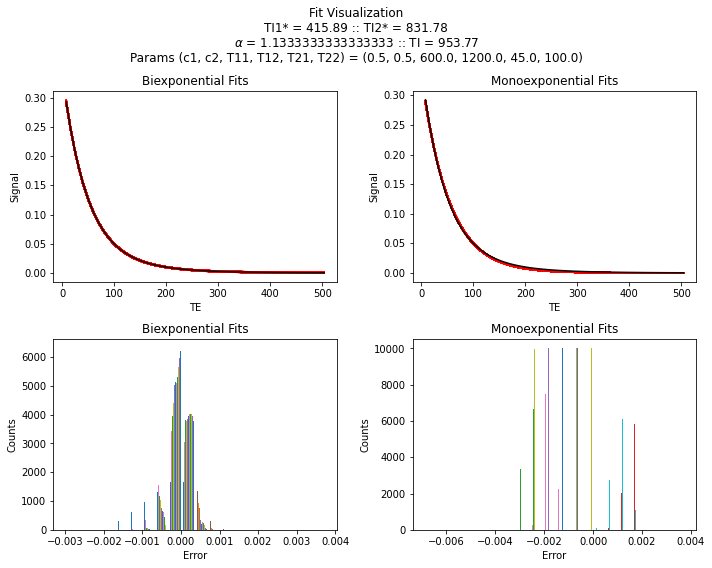

 94%|█████████▍| 67/71 [1:54:06<03:52, 58.21s/it]

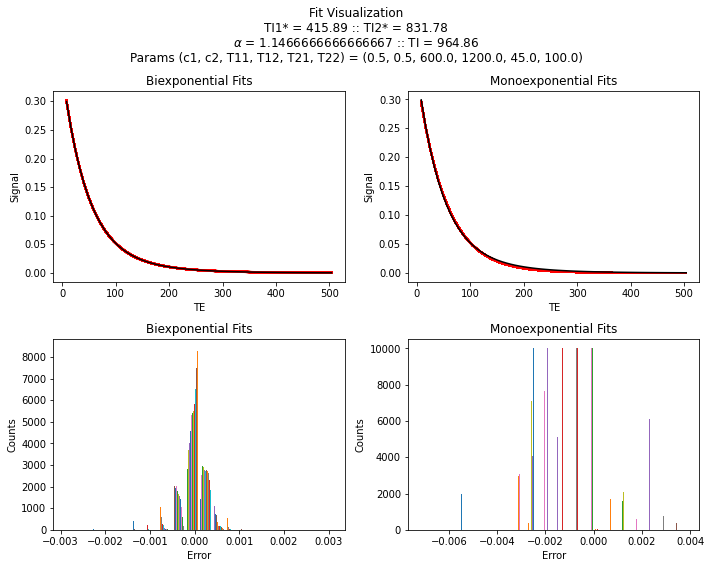

 96%|█████████▌| 68/71 [1:54:55<02:45, 55.31s/it]

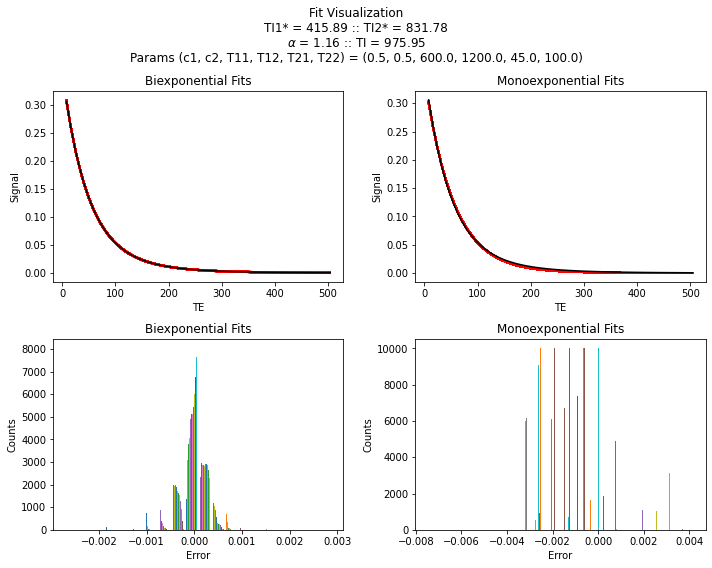

 97%|█████████▋| 69/71 [1:55:39<01:43, 51.98s/it]

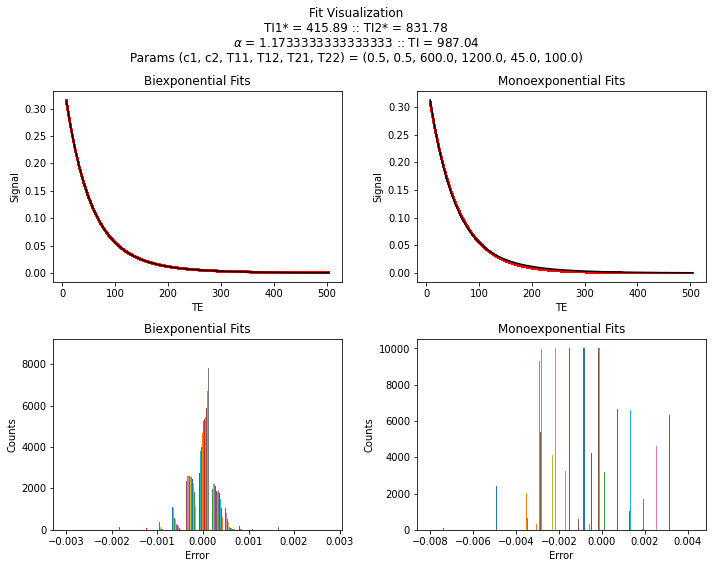

 99%|█████████▊| 70/71 [1:56:23<00:49, 49.50s/it]

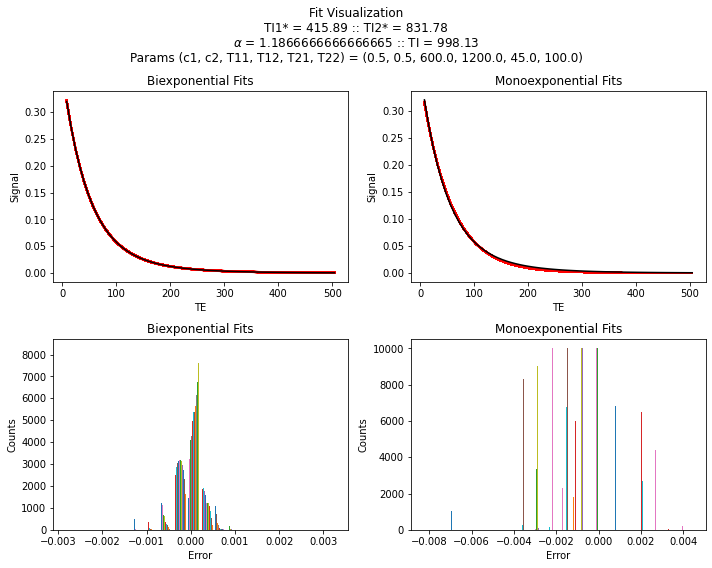

100%|██████████| 71/71 [1:57:06<00:00, 98.97s/it]


In [6]:
#Looping through all TI values in the TI_array
for k in trange(np.size(TI_array)):

    TI = TI_array[k]

    true_d1 = d_value(TI, c1, T11)
    true_d2 = d_value(TI, c2, T12)

    realParams = np.array([true_d1, true_d2, T21, T22])

    trueDat_4p = S_biX_4p(TE_series, *realParams)
    trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

    assert(np.allclose(trueDat,trueDat_4p))
        
    i = 0
    #while loop so that if a lowest parameter value isn't found then we just do it again
    while i < iterCount:

        #Determining the noise and add noise to data
        noiseSigma = 1/SNR
        noise = np.random.normal(0,noiseSigma,TE_series.size)
        noiseDat = trueDat + noise

        lb = (-1,-1,0,0)
        ub = (1,1,T2_bound,T2_bound)
        init_p = realParams

        lb_1E = (-1,0)
        ub_1E = (1,T2_bound)
        init_p_1E = ((true_d1 + true_d2)/2 , (T21 + T22)/2)

        try:
            popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub])
            popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, noiseDat, p0 = init_p_1E, bounds = [lb_1E,ub_1E])
        except Exception as e:
            print(e)
            print("Rerunning this iteration = " + str(i))
            continue

        #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place
        if (popt_2E[3] < popt_2E[2]): #We want by convention to make sure 
            p_hold = popt_2E[0]
            popt_2E[0] = popt_2E[1]
            popt_2E[1] = p_hold
            p_hold = popt_2E[2]
            popt_2E[2] = popt_2E[3]
            popt_2E[3] = p_hold

        paramStore_2E[k,i,:] = popt_2E
        paramStore_1E[k,i,:] = popt_1E

        #Calculate Condition Number
        B = Jacobian_4p(TE_series, *popt_2E) 
        covP = np.dot(B.T,B) #*noiseSigma**2

        CN_params = np.reshape(np.diag(covP),(1,-1))
        CNStore[k,i,:] = CN_params

        #Calculate Residual Sum of Squares (RSS) of 2E
        est_Sig = S_biX_4p(TE_series,*popt_2E)
        RSS_Store[k,i] = np.sum((trueDat - est_Sig)**2)
        errStore[k,i] = np.linalg.norm(trueDat - est_Sig, ord = 2)
        sigStore_2E[k,i,:] = est_Sig

        #Calculate Residual Sum of Squares (RSS) of 1E
        est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
        RSS_Store_1E[k,i] = np.sum((trueDat - est_Sig_1E)**2)
        errStore_1E[k,i] = np.linalg.norm(trueDat - est_Sig_1E, ord = 2)
        sigStore_1E[k,i,:] = est_Sig_1E

        i += 1 #iteration step

    avgCNStore[k,:] = np.reshape(np.mean(CNStore[k,:,:], axis = 0),(1,-1))
    avgPStore[k,:] = np.mean(paramStore_2E[k,:,:], axis = 0)
    stdStore[k,:] = np.std(paramStore_2E[k,:,:], axis = 0)
    std2Store[k,:] = np.var(paramStore_2E[k,:,:], axis = 0)**(1/2)
    mono_std[k,:] = np.std(paramStore_1E[k,:,:], axis = 0)

    if histPlot:
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        for ii in range(2):

            #Get a good bin size
            binData = paramStore_2E[:,[2*ii,2*ii+1]]
            binData = np.reshape(binData,-1)
            binW = (np.max(binData) - np.min(binData))/12
            binW = float('%.1g' % binW) #converts everything to a single significant figure
            binMin = 10**(np.floor(np.log10(np.min(binData))))
            binArray = np.arange(binMin, np.max(binData) + binW, binW)

            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramStore_2E[:,2*ii], bins=binArray, color='b', label = ParamTitle_4p[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramStore_2E[:,2*ii+1], bins=binArray, color='g', label = ParamTitle_4p[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=realParams[2*ii], linewidth=1, label= 'True ' + ParamTitle_4p[2*ii], color='red')
            ax[ii].axvline(x=realParams[2*ii+1], linewidth=1, label= 'True ' + ParamTitle_4p[2*ii+1], color='orange')
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\nTI1* = ' + str(round(TI1star,2)) + ' :: TI2* = ' + str(round(TI2star,2)) + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) +
                        '\nTrue ' + ParamTitle_4p[2*ii] + '=' + str(round(realParams[2*ii],2)) + ' :: ' 
                        'True ' + ParamTitle_4p[2*ii+1] + '=' + str(round(realParams[2*ii+1],2)))
        fig.tight_layout()
        plt.show()

    if denPlot:
        fig, ax = plt.subplots(2,2, figsize=(10,8), tight_layout=True)

        fig.suptitle('Fit Visualization' + 
                        '\nTI1* = ' + str(round(TI1star,2)) + ' :: TI2* = ' + str(round(TI2star,2)) + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) + 
                        '\nParams (' + pTitleList + ') = ' + '('+ pList + ')')
        
        for rep in range(iterCount):
            ax[0,0].plot(TE_series, sigStore_2E[k,rep,:], color='r', alpha = 0.5)
            ax[0,1].plot(TE_series, sigStore_1E[k,rep,:], color='r', alpha = 0.5)

        ax[0,0].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
        ax[0,1].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)

        ax[0,0].set_xlabel("TE")
        ax[0,1].set_xlabel("TE")
        ax[0,0].set_ylabel("Signal")
        ax[0,1].set_ylabel("Signal")
        ax[0,0].set_title("Biexponential Fits")
        ax[0,1].set_title("Monoexponential Fits")

        ax[1,0].hist(x = (sigStore_2E[k,:,:] - trueDat), bins = 20)
        ax[1,1].hist(x = (sigStore_1E[k,:,:] - trueDat), bins = 20)

        ax[1,0].set_xlabel("Error")
        ax[1,1].set_xlabel("Error")
        ax[1,0].set_ylabel("Counts")
        ax[1,1].set_ylabel("Counts")
        ax[1,0].set_title("Biexponential Fits")
        ax[1,1].set_title("Monoexponential Fits")

        plt.show()

# Plotting

### Standard Deviation

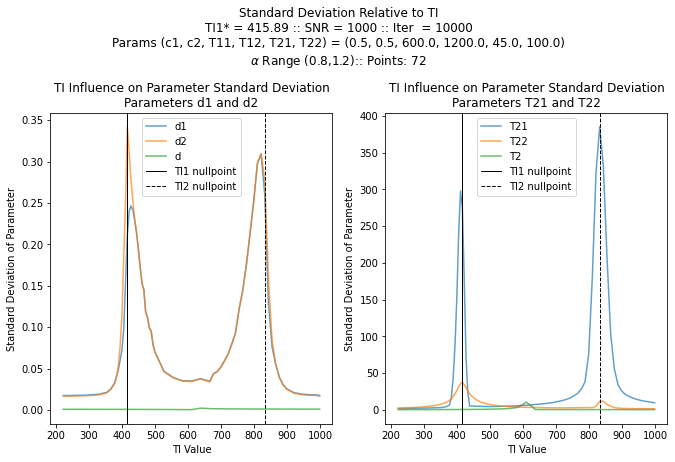

In [7]:
if stdPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    fig.suptitle('Standard Deviation Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array,stdStore[:,2*i], label = ParamTitle_4p[2*i], alpha = 0.7)
        ax[i].plot(TI_array,stdStore[:,2*i+1], label = ParamTitle_4p[2*i+1], alpha = 0.7)
        ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Standard Deviation of Parameter')
        ax[i].set_title('TI Influence on Parameter Standard Deviation' + '\nParameters ' + ParamTitle_4p[2*i] + ' and ' + ParamTitle_4p[2*i+1])
        ax[i].legend()
    plt.show()

### Condition Number Plots

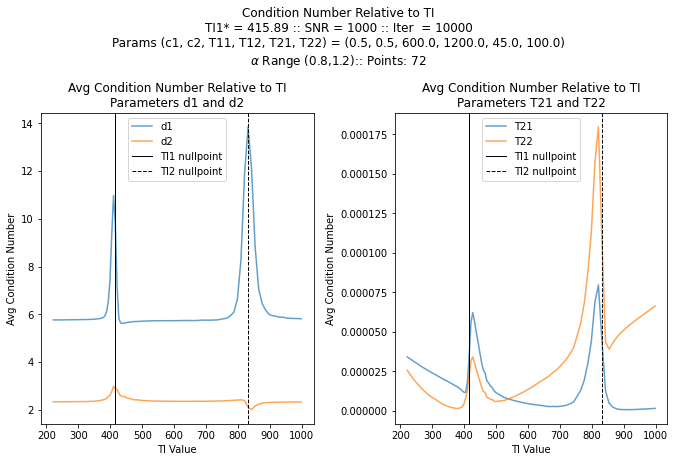

C:\Users\hamptong2\AppData\Local\Temp\ipykernel_8376\1017958247.py:17: RuntimeWarning: divide by zero encountered in divide
  CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run
C:\Users\hamptong2\AppData\Local\Temp\ipykernel_8376\1017958247.py:17: RuntimeWarning: invalid value encountered in divide
  CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run


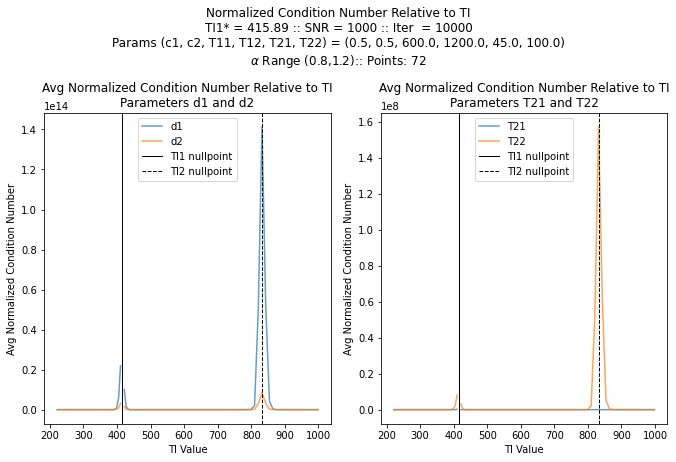

In [24]:
if cNPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    fig.suptitle('Condition Number Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array,avgCNStore[:,2*i], label = ParamTitle_4p[2*i], alpha = 0.7)
        ax[i].plot(TI_array,avgCNStore[:,2*i+1], label = ParamTitle_4p[2*i+1], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Avg Condition Number')
        ax[i].set_title('Avg Condition Number Relative to TI' +
                            '\nParameters ' + ParamTitle_4p[2*i] + ' and ' + ParamTitle_4p[2*i+1])
        ax[i].legend()
    plt.show()


CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run
CN_normalized = np.mean(CN_normalized, axis = 1)


fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
fig.suptitle('Normalized Condition Number Relative to TI' + details)
for i in range(2):
    ax[i].plot(TI_array,CN_normalized[:,2*i], label = ParamTitle_4p[2*i], alpha = 0.7)
    ax[i].plot(TI_array,CN_normalized[:,2*i+1], label = ParamTitle_4p[2*i+1], alpha = 0.7)
    ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
    ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
    ax[i].set_xlabel('TI Value')
    ax[i].set_ylabel('Avg Normalized Condition Number')
    # ax[i].set_ylim([0,10])
    ax[i].set_title('Avg Normalized Condition Number Relative to TI' +
                        '\nParameters ' + ParamTitle_4p[2*i] + ' and ' + ParamTitle_4p[2*i+1])
    ax[i].legend()
plt.show()

### Residual Sum of Squares Plot

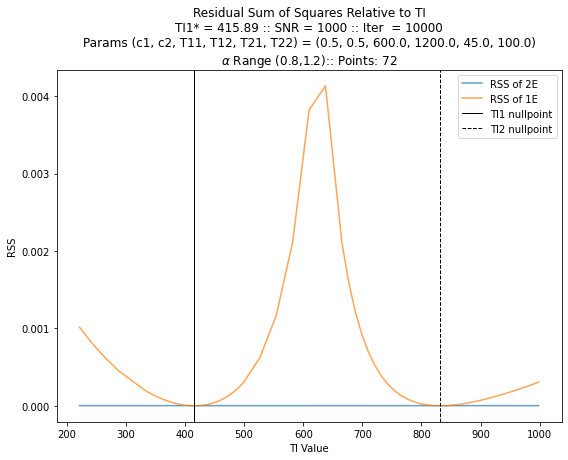

In [ ]:
RSS_avg = np.mean(RSS_Store,axis = 1)
RSS_avg_1E = np.mean(RSS_Store_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,RSS_avg, label = 'RSS of 2E', alpha = 0.7)
plt.plot(TI_array,RSS_avg_1E, label = 'RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Residual Sum of Squares Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

### L2 Norm Plot

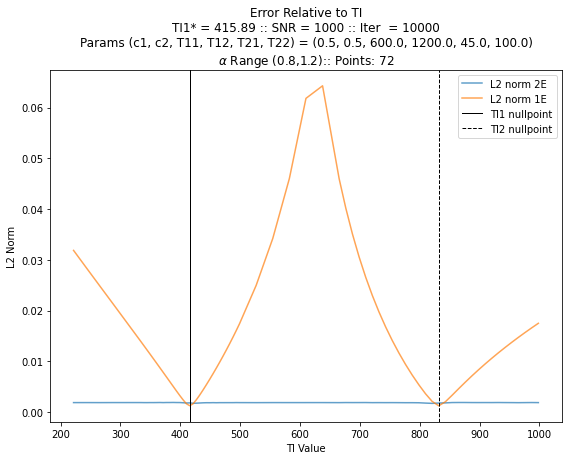

In [ ]:
Err_avg = np.mean(errStore,axis = 1)
Err_avg_1E = np.mean(errStore_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,Err_avg, label = 'L2 norm 2E', alpha = 0.7)
plt.plot(TI_array,Err_avg_1E, label = 'L2 norm 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('L2 Norm')
plt.title('Error Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

### Information Criteria - AIC, BIC, R2, Cp

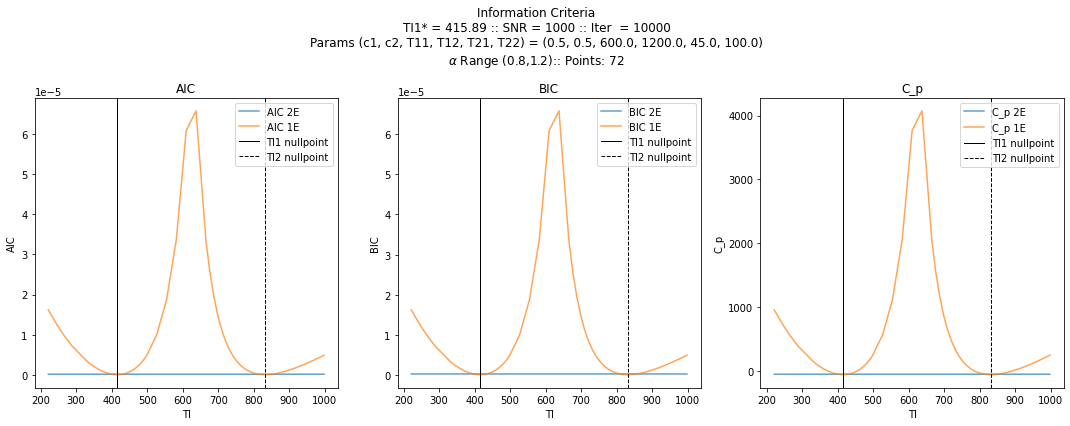

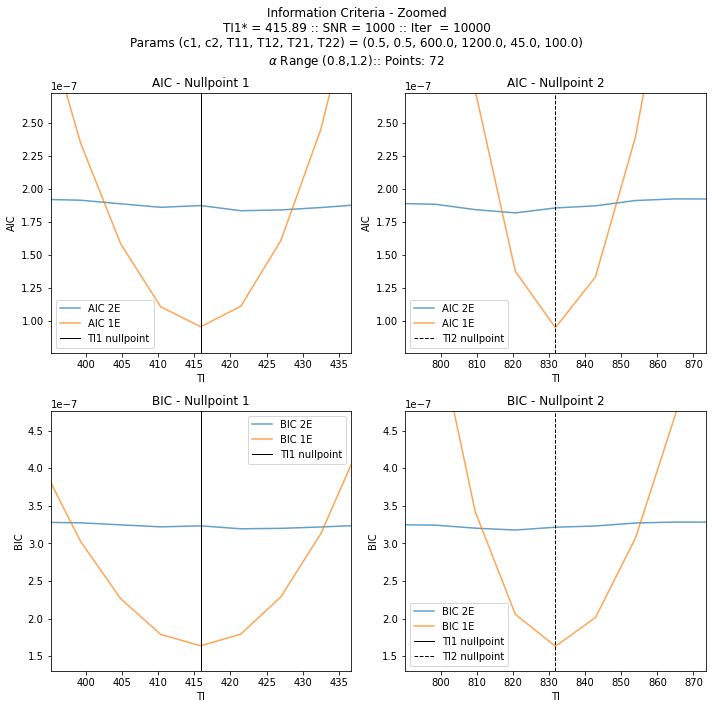

In [ ]:
AIC_2E = 1/TE_series.shape[0] * (RSS_avg + 2 * np.size(ParamTitle_4p)*noiseSigma**2)
AIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + 2 * np.size(MonoTitle)*noiseSigma**2)

BIC_2E = 1/TE_series.shape[0] * (RSS_avg + np.log(TE_series.shape[0]) * np.size(ParamTitle_4p)*noiseSigma**2)
BIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + np.log(TE_series.shape[0]) * np.size(MonoTitle)*noiseSigma**2)

Cp_2E = RSS_avg/noiseSigma**2 + 2*np.size(ParamTitle_4p) - TE_series.shape[0]
Cp_1E = RSS_avg_1E/noiseSigma**2 + 2*np.size(MonoTitle) - TE_series.shape[0]

fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
fig.suptitle('Information Criteria' + details)


ax[0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0].set_title('AIC')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('AIC')
ax[0].legend()

ax[1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1].set_title('BIC')
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('BIC')
ax[1].legend()

ax[2].plot(TI_array, Cp_2E, label = 'C_p 2E', alpha = 0.7)
ax[2].plot(TI_array, Cp_1E, label = 'C_p 1E', alpha = 0.7)
ax[2].set_title('C_p')
ax[2].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[2].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[2].set_xlabel('TI')
ax[2].set_ylabel('C_p')
ax[2].legend()

fig, ax = plt.subplots(2,2,figsize=(10,10), tight_layout=True)
fig.suptitle('Information Criteria - Zoomed' + details)

minVal_1E = min(AIC_1E)
minVal_2E = min(AIC_2E)
ax[0,0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0,0].set_title('AIC - Nullpoint 1')
ax[0,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0,0].set_xlabel('TI')
ax[0,0].set_ylabel('AIC')
ax[0,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,0].set_xlim([(1-rad)*TI1star, (1+rad)*TI1star])
ax[0,0].legend()

ax[0,1].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,1].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0,1].set_title('AIC - Nullpoint 2')
ax[0,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0,1].set_xlabel('TI')
ax[0,1].set_ylabel('AIC')
ax[0,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,1].set_xlim([(1-rad)*TI2star, (1+rad)*TI2star])
ax[0,1].legend()

minVal_1E = min(BIC_1E)
minVal_2E = min(BIC_2E)
ax[1,0].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,0].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1,0].set_title('BIC - Nullpoint 1')
ax[1,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,0].set_xlabel('TI')
ax[1,0].set_ylabel('BIC')
ax[1,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,0].set_xlim([(1-rad)*TI1star, (1+rad)*TI1star])
ax[1,0].legend()

ax[1,1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1,1].set_title('BIC - Nullpoint 2')
ax[1,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1,1].set_xlabel('TI')
ax[1,1].set_ylabel('BIC')
ax[1,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,1].set_xlim([(1-rad)*TI2star, (1+rad)*TI2star])
ax[1,1].legend()

# minVal_1E = min(Cp_1E)
# minVal_2E = min(Cp_2E)
# ax[2].plot(TI_array, Cp_2E, label = 'C_p 2E', alpha = 0.7)
# ax[2].plot(TI_array, Cp_1E, label = 'C_p 1E', alpha = 0.7)
# ax[2].set_title('C_p')
# ax[2].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
# ax[2].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
# ax[2].set_xlabel('TI')
# ax[2].set_ylabel('C_p')
# ax[2].set_ylim(1.2*minVal_1E,0.5*minVal_2E)
# ax[2].legend()


### Sensitivity Graphs

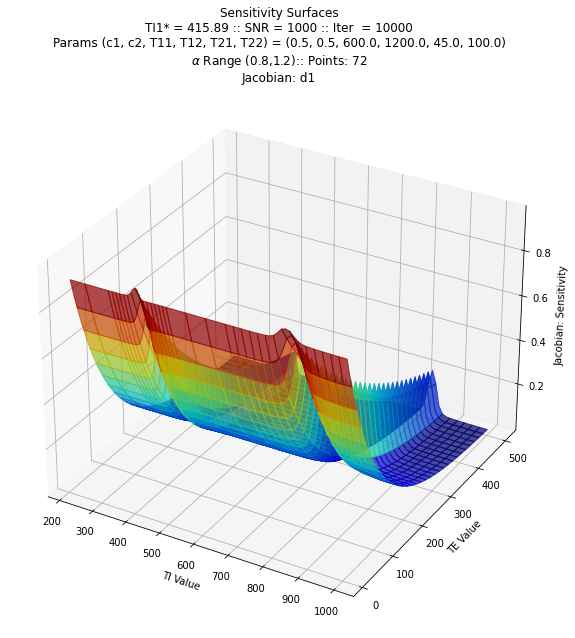

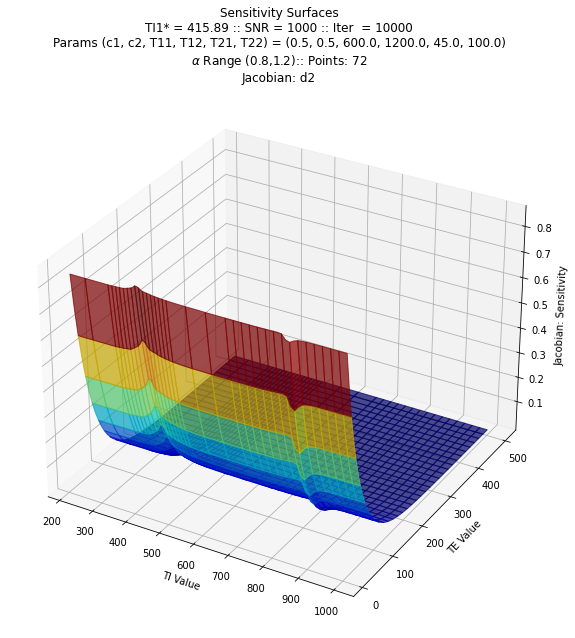

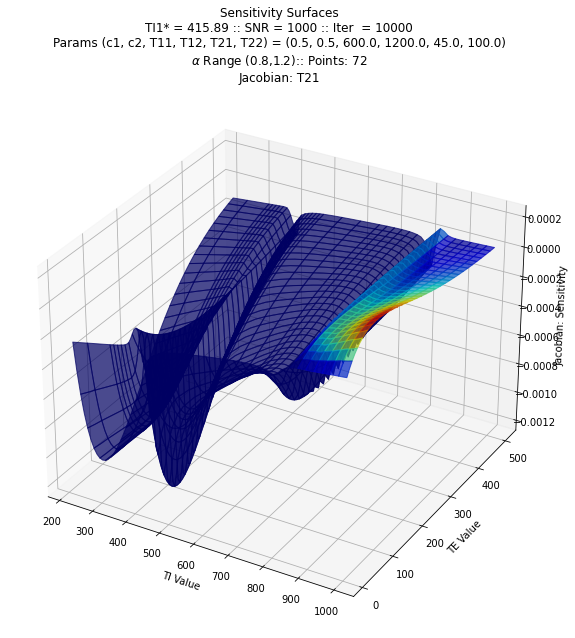

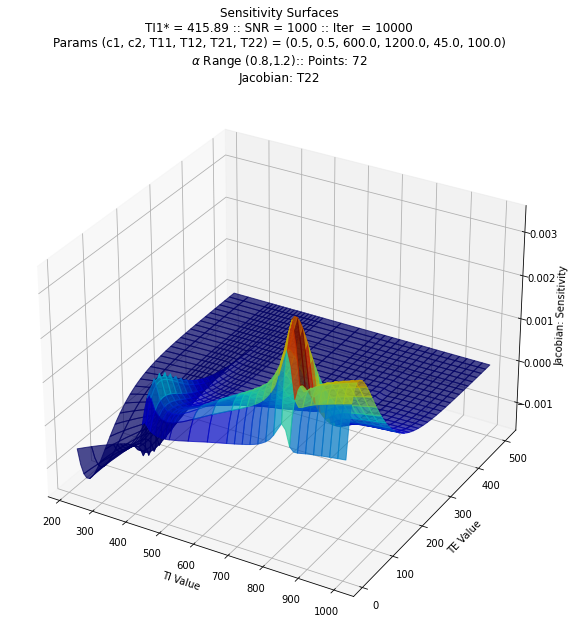

<Figure size 432x288 with 0 Axes>

In [ ]:
TImg,TEmg = np.meshgrid(TI_array,TE_series)
Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(ParamTitle_4p)))
for i in range(Jstore.shape[0]):
    for j in range(Jstore.shape[1]):
        Jstore[i,j,:] = Jacobian_4p(TEmg[i,j],*avgPStore[j,:])



for j in range(Jstore.shape[2]):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    my_col = cm.jet(Jstore[:,:,j]/np.amax(Jstore[:,:,j]))
    ax.plot_surface(TImg,TEmg,Jstore[:,:,j], alpha = 0.7, facecolors = my_col)
    ax.set_xlabel('TI Value')
    ax.set_ylabel('TE Value')
    ax.set_zlabel('Jacobian: Sensitivity')
    ax.set_title('Sensitivity Surfaces' + details + '\nJacobian: ' + ParamTitle_4p[j])
    plt.show()



plt.tight_layout()
plt.show()